In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from bliss.encoders.detection import DetectionEncoder
from bliss.encoders.layers import ConcatBackgroundTransform

import matplotlib.pyplot as plt 
import torch
from astropy.table import Table
from bliss.datasets.table_utils import column_to_tensor

from bliss.datasets.table_utils import column_to_tensor
from astropy.table import Table
from bliss.datasets.lsst import get_default_lsst_psf, get_default_lsst_background
from bliss.datasets.background import add_noise_and_background


from einops import rearrange

# dataset
from bliss.datasets.galsim_blends import generate_dataset, SavedGalsimBlends, parse_dataset



In [ ]:
!echo $CUDA_VISIBLE_DEVICES

5


## New dataset is working

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 50

dataset = generate_dataset(n_samples, catsim_table, all_star_mags, psf, max_n_sources=10, add_galaxies_in_padding=False)

100%|██████████| 50/50 [00:00<00:00, 51.25it/s]


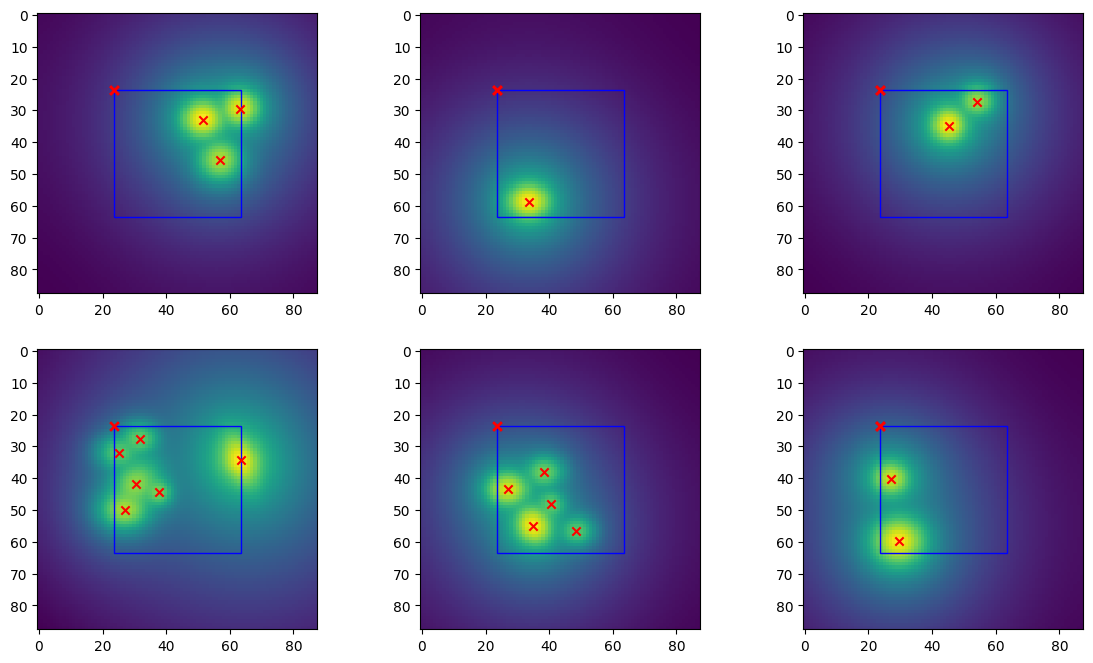

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = dataset['noiseless'][idx][0]

    ax.imshow(np.log10(image), interpolation='none')

    # square of 8 pixels centered
    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')
    

In [ ]:
# attempt creating dataset

import torch
torch.save(dataset, 'test_ds.pt')


saved_ds = SavedGalsimBlends('test_ds.pt', epoch_size=n_samples )

In [ ]:
saved_ds[0]['images'].shape, saved_ds[0]['images'].dtype

(torch.Size([1, 88, 88]), torch.float32)

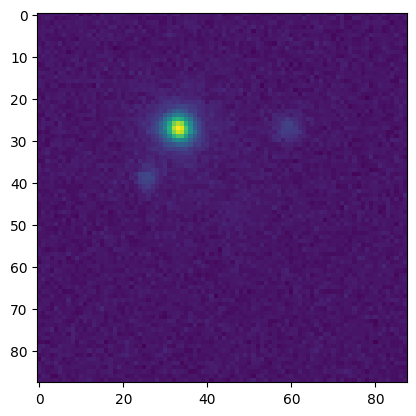

In [ ]:
plt.imshow(saved_ds[4]['images'][0])

In [ ]:
# dataloaders
from torch.utils.data import DataLoader
dl = DataLoader(saved_ds, batch_size=2, shuffle=True)

In [ ]:
# should work
for b in dl: 
    print(b['images'].shape)

torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])
torch.Size([2, 1, 88, 88])


In [ ]:
# splitting in tiles also works 
from bliss.render_tiles import get_images_in_tiles
tiled_images = get_images_in_tiles(b['images'], 4, 52)
tiled_images.shape

torch.Size([2, 10, 10, 1, 52, 52])

In [ ]:
# draw all tiles in a single image 
# rearrange()

### Bright sources

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 20

new_table = catsim_table
catsim_table['i_ab'] = 21

dataset = generate_dataset(n_samples, new_table, all_star_mags, 7, 10, psf)

100%|██████████| 20/20 [00:00<00:00, 29.33it/s]


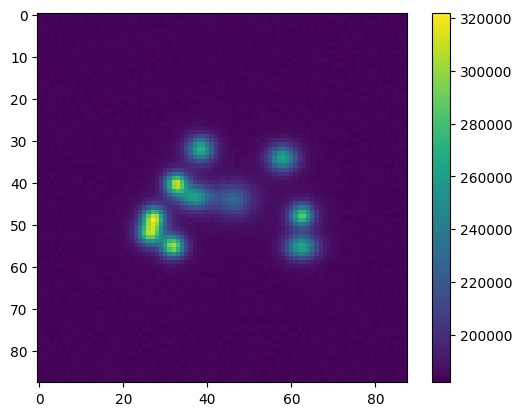

In [ ]:
plt.imshow(dataset['images'][3,0])
plt.colorbar()

## Overfitting detection encoder 

In [ ]:
# let's try to overfit a detection encoder
# for now in the cpu with one or two batches.
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)


In [ ]:
# first check if encoding and getting loss works for a batch

# get one batch and parse it
for batch in dl: 
    continue
images, background, truth_catalog = parse_dataset(batch)

In [ ]:
# forward works
n_sources_log_prob, _, _ = detection_encoder.forward(images, background)
n_sources_log_prob.shape, n_sources_log_prob[0]

(torch.Size([200]), tensor(0.5141, grad_fn=<SelectBackward0>))

In [ ]:
# get loss works
losses = detection_encoder.get_loss(images, background, truth_catalog)
losses['counter_loss']

0.6843138337135315

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)
opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in range(100):
    opt.zero_grad()
    # same batch every step
    loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    loss.backward()
    opt.step()
    if ii % 25==0:
        print(ii, ': ', loss.detach().item())


0 :  0.795698881149292
25 :  0.223222553730011
50 :  0.0341634526848793
75 :  -0.09179598093032837


In [ ]:
probs, _, _ = detection_encoder.forward(images, background)
probs

tensor([0.2166, 0.2233, 0.2142, 0.2102, 0.2325, 0.2104, 0.2137, 0.2068, 0.2212,
        0.2533, 0.2147, 0.2174, 0.2103, 0.2048, 0.2019, 0.2067, 0.9186, 0.2130,
        0.2519, 0.2167, 0.9403, 0.2153, 0.2107, 0.8808, 0.2322, 0.2244, 0.2190,
        0.2296, 0.2065, 0.9482, 0.1983, 0.2286, 0.2092, 0.2242, 0.2168, 0.2207,
        0.2250, 0.2136, 0.1993, 0.2172, 0.2332, 0.2298, 0.2533, 0.9506, 0.2281,
        0.2067, 0.2056, 0.2214, 0.2318, 0.2143, 0.2097, 0.2123, 0.2090, 0.1979,
        0.2022, 0.2118, 0.2043, 0.2201, 0.2081, 0.9315, 0.2185, 0.2172, 0.2090,
        0.2253, 0.8780, 0.2194, 0.1990, 0.2213, 0.2057, 0.2120, 0.2229, 0.2121,
        0.2227, 0.2058, 0.2105, 0.1969, 0.2044, 0.2022, 0.2083, 0.1913, 0.2141,
        0.2189, 0.2010, 0.2105, 0.2383, 0.2084, 0.2112, 0.2126, 0.2226, 0.2094,
        0.2088, 0.2252, 0.2158, 0.2107, 0.2044, 0.2043, 0.2252, 0.2011, 0.9421,
        0.1991, 0.2029, 0.2049, 0.9488, 0.2262, 0.2132, 0.2070, 0.1956, 0.2097,
        0.2112, 0.2066, 0.1993, 0.2161, 

In [ ]:
# get predictions
detection_encoder.eval()
with torch.no_grad():
    pred_cat = detection_encoder.variational_mode(images, background)

In [ ]:
# it can overfit number of sources!
assert torch.all(torch.eq(truth_catalog.n_sources, pred_cat.n_sources))

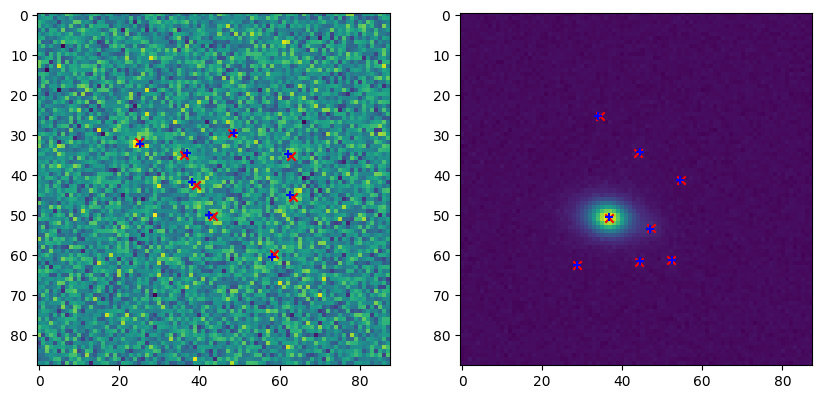

In [ ]:
# what about locations?
# let's plot them
# definitely learning about locations over time, not perfect with only few epochs
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
plocs1 = truth_catalog.to_full_params().plocs.detach().numpy()
plocs2 = pred_cat.to_full_params().plocs.detach().numpy()

for ii, ax in enumerate(axes.flat):
    ax.imshow(images[ii, 0])
    ax.scatter(plocs1[ii, :, 1] + 24 - 0.5, plocs1[ii, :, 0] + 24 - 0.5, marker='x', color='r')
    ax.scatter(plocs2[ii, :, 1] + 24 - 0.5, plocs2[ii, :, 0] + 24 - 0.5, marker='+', color='b')

## Check validation loss goes down in GPU

In [ ]:
# NOTES: 
# it does go down but why does the training loss explode sometimes?
# try larger dataset --> does not help
# try smaller learning rate

In [ ]:
import torch
gpu = torch.device("cuda:0")

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples =99
dataset = generate_dataset(n_samples, catsim_table, all_star_mags, 4, 10, psf)

100%|██████████| 99/99 [00:02<00:00, 43.60it/s]


In [ ]:
# train, test split
train_idx = 98
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds.pt")
torch.save(val_ds, "val_ds.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds.pt", 98)
validation_dataset = SavedGalsimBlends("val_ds.pt", 1)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=32)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(100), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   5%|▌         | 5/100 [00:07<02:29,  1.57s/it]

epoch: 4 ,training_loss:  0.6583302021026611
epoch: 4 ,counter_training_loss:  0.5879024416208267
epoch: 4 ,counter_locs_loss:  0.07042772881686687


epoch::  10%|█         | 10/100 [00:15<02:21,  1.58s/it]

epoch: 9 ,training_loss:  0.5938577055931091
epoch: 9 ,counter_training_loss:  0.5370435267686844
epoch: 9 ,counter_locs_loss:  0.056814136914908886


epoch::  15%|█▌        | 15/100 [00:23<02:14,  1.59s/it]

epoch: 14 ,training_loss:  0.4968624487519264
epoch: 14 ,counter_training_loss:  0.430988572537899
epoch: 14 ,counter_locs_loss:  0.06587386410683393


epoch::  20%|██        | 20/100 [00:31<02:07,  1.59s/it]

epoch: 19 ,training_loss:  0.46155524998903275
epoch: 19 ,counter_training_loss:  0.40277059376239777
epoch: 19 ,counter_locs_loss:  0.058784667402505875


epoch::  25%|██▌       | 25/100 [00:39<01:59,  1.60s/it]

epoch: 24 ,training_loss:  0.40222684293985367
epoch: 24 ,counter_training_loss:  0.35891110450029373
epoch: 24 ,counter_locs_loss:  0.04331572982482612


epoch::  30%|███       | 30/100 [00:47<01:52,  1.60s/it]

epoch: 29 ,training_loss:  0.40452464669942856
epoch: 29 ,counter_training_loss:  0.35914117097854614
epoch: 29 ,counter_locs_loss:  0.04538347199559212


epoch::  35%|███▌      | 35/100 [00:55<01:44,  1.61s/it]

epoch: 34 ,training_loss:  0.3453054800629616
epoch: 34 ,counter_training_loss:  0.31443652510643005
epoch: 34 ,counter_locs_loss:  0.03086894261650741


epoch::  40%|████      | 40/100 [01:03<01:36,  1.61s/it]

epoch: 39 ,training_loss:  0.31584448367357254
epoch: 39 ,counter_training_loss:  0.29073455184698105
epoch: 39 ,counter_locs_loss:  0.02510994509793818


epoch::  45%|████▌     | 45/100 [01:11<01:28,  1.61s/it]

epoch: 44 ,training_loss:  0.2997925356030464
epoch: 44 ,counter_training_loss:  0.2781075984239578
epoch: 44 ,counter_locs_loss:  0.021684941835701466


epoch::  50%|█████     | 50/100 [01:19<01:20,  1.61s/it]

epoch: 49 ,training_loss:  0.29638009518384933
epoch: 49 ,counter_training_loss:  0.2839137502014637
epoch: 49 ,counter_locs_loss:  0.012466336280340329


epoch::  55%|█████▌    | 55/100 [01:27<01:12,  1.62s/it]

epoch: 54 ,training_loss:  0.2676462195813656
epoch: 54 ,counter_training_loss:  0.2549026720225811
epoch: 54 ,counter_locs_loss:  0.012743551400490105


epoch::  60%|██████    | 60/100 [01:35<01:04,  1.62s/it]

epoch: 59 ,training_loss:  0.24673281237483025
epoch: 59 ,counter_training_loss:  0.23943988233804703
epoch: 59 ,counter_locs_loss:  0.007292926631635055


epoch::  65%|██████▌   | 65/100 [01:44<00:56,  1.62s/it]

epoch: 64 ,training_loss:  0.2270638272166252
epoch: 64 ,counter_training_loss:  0.22770901024341583
epoch: 64 ,counter_locs_loss:  -0.0006451843655668199


epoch::  70%|███████   | 70/100 [01:52<00:48,  1.62s/it]

epoch: 69 ,training_loss:  0.20685141533613205
epoch: 69 ,counter_training_loss:  0.2207743041217327
epoch: 69 ,counter_locs_loss:  -0.013922892045229673


epoch::  75%|███████▌  | 75/100 [02:00<00:40,  1.62s/it]

epoch: 74 ,training_loss:  0.22076989710330963
epoch: 74 ,counter_training_loss:  0.22957245633006096
epoch: 74 ,counter_locs_loss:  -0.008802550844848156


epoch::  80%|████████  | 80/100 [02:08<00:32,  1.62s/it]

epoch: 79 ,training_loss:  0.18322674557566643
epoch: 79 ,counter_training_loss:  0.20922015607357025
epoch: 79 ,counter_locs_loss:  -0.0259934205096215


epoch::  85%|████████▌ | 85/100 [02:16<00:24,  1.62s/it]

epoch: 84 ,training_loss:  0.16442350670695305
epoch: 84 ,counter_training_loss:  0.1949959434568882
epoch: 84 ,counter_locs_loss:  -0.030572444666177034


epoch::  90%|█████████ | 90/100 [02:24<00:16,  1.62s/it]

epoch: 89 ,training_loss:  0.14792846515774727
epoch: 89 ,counter_training_loss:  0.18790601566433907
epoch: 89 ,counter_locs_loss:  -0.03997755143791437


epoch::  95%|█████████▌| 95/100 [02:32<00:08,  1.62s/it]

epoch: 94 ,training_loss:  0.1456074509769678
epoch: 94 ,counter_training_loss:  0.17755811661481857
epoch: 94 ,counter_locs_loss:  -0.031950667733326554


epoch:: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]

epoch: 99 ,training_loss:  0.15768763236701488
epoch: 99 ,counter_training_loss:  0.1878024823963642
epoch: 99 ,counter_locs_loss:  -0.03011485282331705


In [ ]:
# for vbatch in val_dl: 
#     break

# plt.imshow(vbatch['images'][0,0])

In [ ]:
# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

pred_cat.n_sources.nonzero()

In [ ]:
for tbatch in train_dl:
    break

In [ ]:
# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
pred_cat.to_full_params().n_sources

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 8])

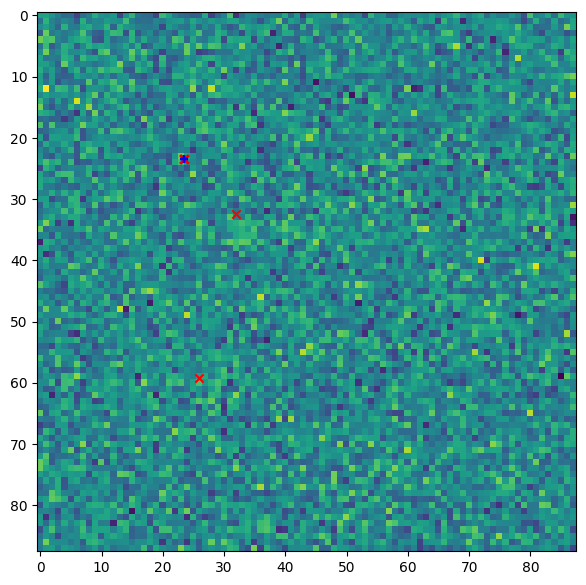

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plocs1 = truth_cat.to_full_params().plocs.detach().numpy()
plocs2 = pred_cat.to_full_params().plocs.detach().numpy()
ii=24
ax.imshow(images[ii, 0])
ax.scatter(plocs1[ii, :, 1] + 24 - 0.5, plocs1[ii, :, 0] + 24 - 0.5, marker='x', color='r')
ax.scatter(plocs2[ii, :, 1] + 24 - 0.5, plocs2[ii, :, 0] + 24 - 0.5, marker='+', color='b')

## Repeat with Old Detection Encoder

In [ ]:
import torch

gpu = torch.device("cuda:0")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds.pt", 1000)
validation_dataset = SavedGalsimBlends("val_ds.pt", 1)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=32)

In [ ]:
# check a single batch in CPU works with loss function
for tbatch in train_dl: 
    break

from bliss.encoders.old_detection import OldDetectionEncoder
input_transform = ConcatBackgroundTransform()
detection_encoder = OldDetectionEncoder(input_transform, 1)

losses = detection_encoder.get_loss(tbatch)
losses['locs_loss']

0.0777064636349678

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm

input_transform = ConcatBackgroundTransform()
detection_encoder = OldDetectionEncoder(input_transform, 1, device=gpu)
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)

# train_losses = [] 
# validation_losses = []


for ii in tqdm(range(15), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        gpu_batch = {p:q.to(gpu) for p,q in tbatch.items()}
        losses = detection_encoder.get_loss(gpu_batch)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    print('epoch:', ii, ',training_loss: ', running_loss)
    print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
    print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 3 == 2:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   0%|          | 0/15 [00:00<?, ?it/s]

epoch::   7%|▋         | 1/15 [00:17<04:02, 17.33s/it]

epoch: 0 ,training_loss:  0.7159464154392481
epoch: 0 ,counter_training_loss:  0.6435247268527746
epoch: 0 ,counter_locs_loss:  0.07242167997173965


epoch::  13%|█▎        | 2/15 [00:33<03:36, 16.68s/it]

epoch: 1 ,training_loss:  0.61267791967839
epoch: 1 ,counter_training_loss:  0.5419714776799083
epoch: 1 ,counter_locs_loss:  0.07070643012411892


epoch::  20%|██        | 3/15 [00:49<03:18, 16.51s/it]

epoch: 2 ,training_loss:  0.5440906910225749
epoch: 2 ,counter_training_loss:  0.4761576736345887
epoch: 2 ,counter_locs_loss:  0.06793302262667567


epoch::  27%|██▋       | 4/15 [01:06<03:01, 16.47s/it]

epoch: 3 ,training_loss:  0.4698151620104909
epoch: 3 ,counter_training_loss:  0.40624776761978865
epoch: 3 ,counter_locs_loss:  0.06356738426256925


epoch::  33%|███▎      | 5/15 [01:22<02:44, 16.47s/it]

epoch: 4 ,training_loss:  0.32512215431779623
epoch: 4 ,counter_training_loss:  0.27267021825537086
epoch: 4 ,counter_locs_loss:  0.05245193256996572


epoch::  40%|████      | 6/15 [01:39<02:28, 16.48s/it]

epoch: 5 ,training_loss:  0.2648379998281598
epoch: 5 ,counter_training_loss:  0.2201491380110383
epoch: 5 ,counter_locs_loss:  0.044688862399198115


epoch::  47%|████▋     | 7/15 [01:55<02:11, 16.49s/it]

epoch: 6 ,training_loss:  0.22698769439011812
epoch: 6 ,counter_training_loss:  0.19037339324131608
epoch: 6 ,counter_locs_loss:  0.03661430528154597


epoch::  53%|█████▎    | 8/15 [02:12<01:55, 16.51s/it]

epoch: 7 ,training_loss:  0.1997347748838365
epoch: 7 ,counter_training_loss:  0.17017327388748527
epoch: 7 ,counter_locs_loss:  0.029561503091827035


epoch::  60%|██████    | 9/15 [02:28<01:39, 16.52s/it]

epoch: 8 ,training_loss:  0.18175365729257464
epoch: 8 ,counter_training_loss:  0.15888235066086054
epoch: 8 ,counter_locs_loss:  0.022871308960020542


epoch::  67%|██████▋   | 10/15 [02:45<01:22, 16.53s/it]

epoch: 9 ,training_loss:  0.1636030012741685
epoch: 9 ,counter_training_loss:  0.1477516391314566
epoch: 9 ,counter_locs_loss:  0.015851362666580826


epoch::  73%|███████▎  | 11/15 [03:01<01:06, 16.53s/it]

epoch: 10 ,training_loss:  0.14337907009758055
epoch: 10 ,counter_training_loss:  0.13594687031581998
epoch: 10 ,counter_locs_loss:  0.00743220219635532


epoch::  80%|████████  | 12/15 [03:18<00:49, 16.54s/it]

epoch: 11 ,training_loss:  0.13687433023005724
epoch: 11 ,counter_training_loss:  0.13171066343784332
epoch: 11 ,counter_locs_loss:  0.00516366693409509


epoch::  87%|████████▋ | 13/15 [03:35<00:33, 16.55s/it]

epoch: 12 ,training_loss:  0.12495457730256021
epoch: 12 ,counter_training_loss:  0.12337590055540204
epoch: 12 ,counter_locs_loss:  0.0015786736340714924


epoch::  93%|█████████▎| 14/15 [03:51<00:16, 16.57s/it]

epoch: 13 ,training_loss:  0.10965669620782137
epoch: 13 ,counter_training_loss:  0.11455119727179408
epoch: 13 ,counter_locs_loss:  -0.004894502497791109


epoch:: 100%|██████████| 15/15 [04:08<00:00, 16.55s/it]

epoch: 14 ,training_loss:  0.10021212045103312
epoch: 14 ,counter_training_loss:  0.10983475809916854
epoch: 14 ,counter_locs_loss:  -0.00962263854307821


## Test on Single tile with only bright sources and always 1 source exactly

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 1408

new_table = catsim_table.copy()
new_table['i_ab'] = 21.0

In [ ]:
dataset = generate_dataset(n_samples, new_table, all_star_mags, 20, 1, psf, slen=4, bp=24, max_shift=0.5, galaxy_prob=1.0) # hack so that there is always 1 source

100%|██████████| 1408/1408 [00:11<00:00, 124.96it/s]


ii tensor([0.9043, 0.1495])
ii tensor([0.5558, 0.7933])
ii tensor([0.9834, 0.7427])


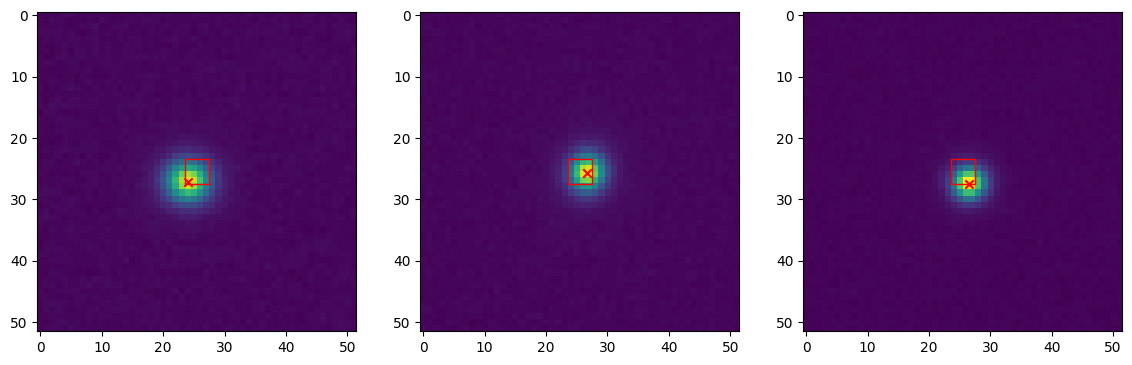

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = 128*10
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_bright.pt")
torch.save(val_ds, "val_ds_bright.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_bright.pt", 128 * 10, slen=4)
validation_dataset = SavedGalsimBlends("train_ds_bright.pt", 128 * 1, slen=4)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(100), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   5%|▌         | 5/100 [00:02<00:41,  2.27it/s]

epoch: 4 ,training_loss:  1.9447309374809265
epoch: 4 ,counter_training_loss:  0.5531499743461609
epoch: 4 ,counter_locs_loss:  1.3915809631347655


epoch::  10%|█         | 10/100 [00:04<00:39,  2.28it/s]

epoch: 9 ,training_loss:  1.4406418919563293
epoch: 9 ,counter_training_loss:  0.4380591869354248
epoch: 9 ,counter_locs_loss:  1.0025827050209046


epoch::  15%|█▌        | 15/100 [00:06<00:37,  2.29it/s]

epoch: 14 ,training_loss:  1.061680221557617
epoch: 14 ,counter_training_loss:  0.36412144303321836
epoch: 14 ,counter_locs_loss:  0.6975588083267212


epoch::  20%|██        | 20/100 [00:08<00:35,  2.29it/s]

epoch: 19 ,training_loss:  0.6896318554878235
epoch: 19 ,counter_training_loss:  0.30192204415798185
epoch: 19 ,counter_locs_loss:  0.38770981729030607


epoch::  25%|██▌       | 25/100 [00:10<00:32,  2.29it/s]

epoch: 24 ,training_loss:  0.32496877312660216
epoch: 24 ,counter_training_loss:  0.25459207892417907
epoch: 24 ,counter_locs_loss:  0.07037668898701668


epoch::  30%|███       | 30/100 [00:13<00:30,  2.28it/s]

epoch: 29 ,training_loss:  -0.03406150043010712
epoch: 29 ,counter_training_loss:  0.21852600574493408
epoch: 29 ,counter_locs_loss:  -0.25258750319480894


epoch::  35%|███▌      | 35/100 [00:15<00:28,  2.29it/s]

epoch: 34 ,training_loss:  -0.411193385720253
epoch: 34 ,counter_training_loss:  0.18760114461183547
epoch: 34 ,counter_locs_loss:  -0.5987945139408112


epoch::  40%|████      | 40/100 [00:17<00:26,  2.29it/s]

epoch: 39 ,training_loss:  -0.7944619655609131
epoch: 39 ,counter_training_loss:  0.16046437472105027
epoch: 39 ,counter_locs_loss:  -0.9549263417720795


epoch::  45%|████▌     | 45/100 [00:19<00:24,  2.29it/s]

epoch: 44 ,training_loss:  -1.1859755158424377
epoch: 44 ,counter_training_loss:  0.13680943697690964
epoch: 44 ,counter_locs_loss:  -1.322784960269928


epoch::  50%|█████     | 50/100 [00:21<00:21,  2.29it/s]

epoch: 49 ,training_loss:  -1.5628352642059327
epoch: 49 ,counter_training_loss:  0.11486514434218406
epoch: 49 ,counter_locs_loss:  -1.6777003884315491


epoch::  55%|█████▌    | 55/100 [00:24<00:19,  2.28it/s]

epoch: 54 ,training_loss:  -1.9686712265014648
epoch: 54 ,counter_training_loss:  0.09650873839855194
epoch: 54 ,counter_locs_loss:  -2.065180015563965


epoch::  60%|██████    | 60/100 [00:26<00:17,  2.29it/s]

epoch: 59 ,training_loss:  -2.3010658025741577
epoch: 59 ,counter_training_loss:  0.08310037925839424
epoch: 59 ,counter_locs_loss:  -2.384166121482849


epoch::  65%|██████▌   | 65/100 [00:28<00:15,  2.29it/s]

epoch: 64 ,training_loss:  -2.651973819732666
epoch: 64 ,counter_training_loss:  0.07140714079141616
epoch: 64 ,counter_locs_loss:  -2.723380994796753


epoch::  70%|███████   | 70/100 [00:30<00:13,  2.27it/s]

epoch: 69 ,training_loss:  -3.049132227897644
epoch: 69 ,counter_training_loss:  0.06143895350396633
epoch: 69 ,counter_locs_loss:  -3.1105712175369264


epoch::  75%|███████▌  | 75/100 [00:32<00:10,  2.28it/s]

epoch: 74 ,training_loss:  -3.312773895263672
epoch: 74 ,counter_training_loss:  0.05456947647035122
epoch: 74 ,counter_locs_loss:  -3.3673433542251585


epoch::  80%|████████  | 80/100 [00:35<00:08,  2.28it/s]

epoch: 79 ,training_loss:  -3.529036450386047
epoch: 79 ,counter_training_loss:  0.04765278995037079
epoch: 79 ,counter_locs_loss:  -3.5766893148422243


epoch::  85%|████████▌ | 85/100 [00:37<00:06,  2.28it/s]

epoch: 84 ,training_loss:  -3.801213598251343
epoch: 84 ,counter_training_loss:  0.04265745095908642
epoch: 84 ,counter_locs_loss:  -3.843871068954468


epoch::  90%|█████████ | 90/100 [00:39<00:04,  2.28it/s]

epoch: 89 ,training_loss:  -3.9877854347229005
epoch: 89 ,counter_training_loss:  0.03814315758645535
epoch: 89 ,counter_locs_loss:  -4.025928640365601


epoch::  95%|█████████▌| 95/100 [00:41<00:02,  2.28it/s]

epoch: 94 ,training_loss:  -4.232182598114013
epoch: 94 ,counter_training_loss:  0.03522143289446831
epoch: 94 ,counter_locs_loss:  -4.267403936386108


epoch:: 100%|██████████| 100/100 [00:43<00:00,  2.28it/s]

epoch: 99 ,training_loss:  -4.209488725662231
epoch: 99 ,counter_training_loss:  0.03344148546457291
epoch: 99 ,counter_locs_loss:  -4.242930221557617


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
truth_cat.n_sources.squeeze(),pred_cat.n_sources.squeeze()

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]))

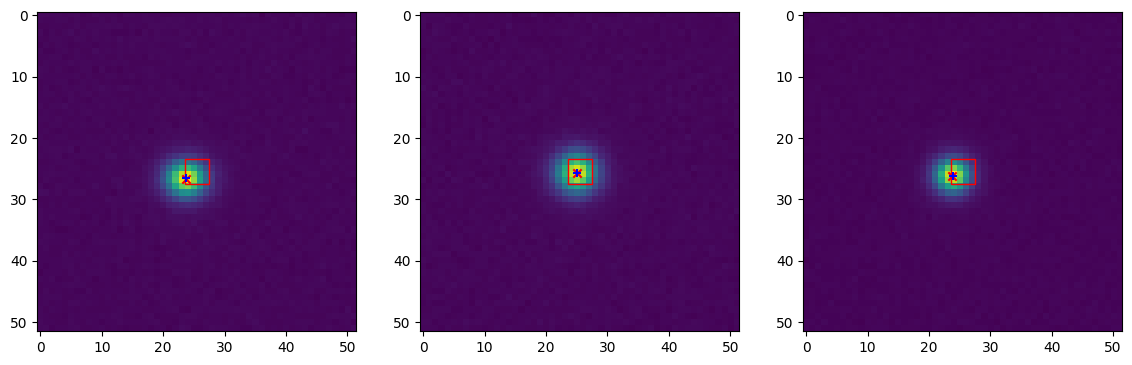

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(tbatch['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

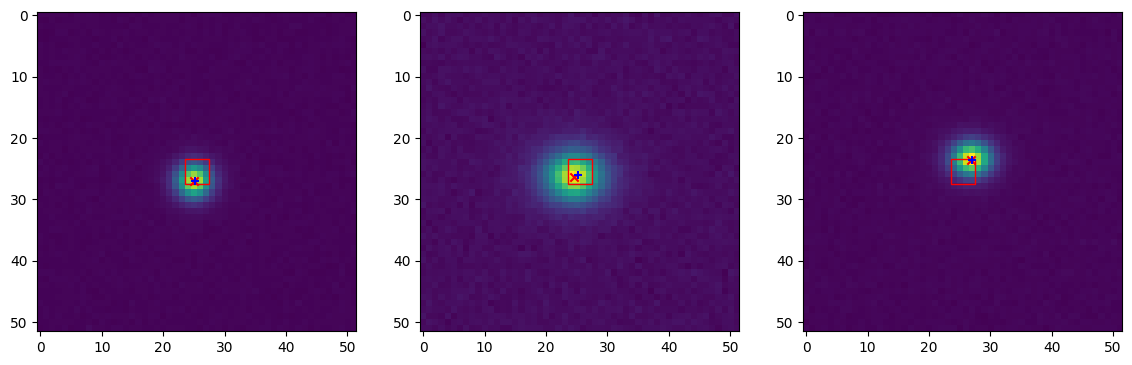

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(vbatch['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


## Sometimes, no sources but still constant bright flux

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

catsim_table['i_ab'] = 21.0
n_samples = 128 * 11

In [ ]:
dataset = generate_dataset(n_samples, catsim_table, all_star_mags, 0.6, 1, psf, slen=4, bp=24, max_shift=0.5, galaxy_prob=1.0) # hack

100%|██████████| 1408/1408 [00:07<00:00, 198.35it/s]


ii tensor([0., 0.])
ii tensor([0.2842, 0.3928])
ii tensor([0.6709, 0.5907])


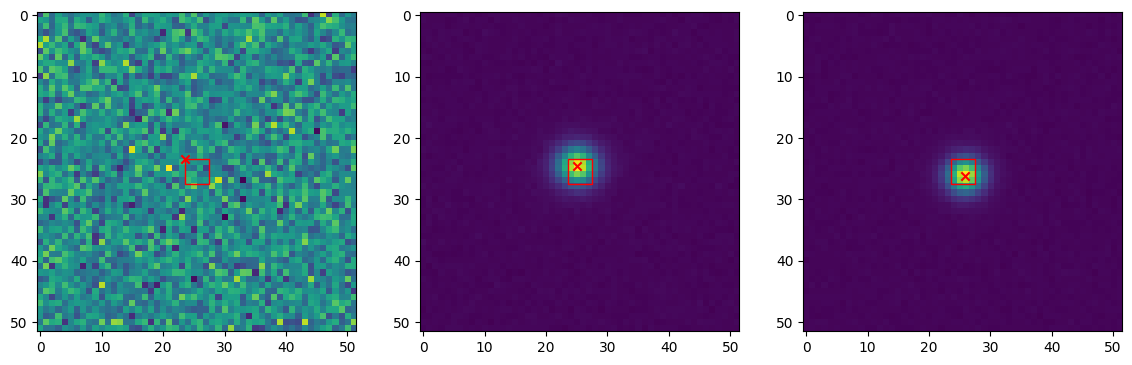

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = 128*10
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_single_bright_on_and_off.pt")
torch.save(val_ds, "val_ds_single_bright_on_and_off.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_single_bright_on_and_off.pt", 128 * 10, slen=4)
validation_dataset = SavedGalsimBlends("val_ds_single_bright_on_and_off.pt", 128 * 1, slen=4)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(100), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   5%|▌         | 5/100 [00:02<00:41,  2.27it/s]

epoch: 4 ,training_loss:  0.19214570969343187
epoch: 4 ,counter_training_loss:  0.22719586044549941
epoch: 4 ,counter_locs_loss:  -0.03505015168339014


epoch::  10%|█         | 10/100 [00:04<00:39,  2.31it/s]

epoch: 9 ,training_loss:  -0.11486974656581879
epoch: 9 ,counter_training_loss:  0.17542530596256256
epoch: 9 ,counter_locs_loss:  -0.29029505848884585


epoch::  15%|█▌        | 15/100 [00:06<00:36,  2.31it/s]

epoch: 14 ,training_loss:  -0.3636817246675491
epoch: 14 ,counter_training_loss:  0.13537679016590118
epoch: 14 ,counter_locs_loss:  -0.4990585058927536


epoch::  20%|██        | 20/100 [00:08<00:34,  2.30it/s]

epoch: 19 ,training_loss:  -0.588783460855484
epoch: 19 ,counter_training_loss:  0.11028788909316063
epoch: 19 ,counter_locs_loss:  -0.6990713477134705


epoch::  25%|██▌       | 25/100 [00:10<00:32,  2.29it/s]

epoch: 24 ,training_loss:  -0.8081972360610962
epoch: 24 ,counter_training_loss:  0.0910896323621273
epoch: 24 ,counter_locs_loss:  -0.8992868602275849


epoch::  30%|███       | 30/100 [00:13<00:30,  2.30it/s]

epoch: 29 ,training_loss:  -0.9730751812458038
epoch: 29 ,counter_training_loss:  0.07596457004547119
epoch: 29 ,counter_locs_loss:  -1.0490397691726685


epoch::  35%|███▌      | 35/100 [00:15<00:28,  2.31it/s]

epoch: 34 ,training_loss:  -1.1990458369255066
epoch: 34 ,counter_training_loss:  0.06286612898111343
epoch: 34 ,counter_locs_loss:  -1.2619119882583618


epoch::  40%|████      | 40/100 [00:17<00:26,  2.31it/s]

epoch: 39 ,training_loss:  -1.2755560517311095
epoch: 39 ,counter_training_loss:  0.05422919653356075
epoch: 39 ,counter_locs_loss:  -1.3297852277755737


epoch::  45%|████▌     | 45/100 [00:19<00:23,  2.30it/s]

epoch: 44 ,training_loss:  -1.389189076423645
epoch: 44 ,counter_training_loss:  0.047300441190600395
epoch: 44 ,counter_locs_loss:  -1.436489510536194


epoch::  50%|█████     | 50/100 [00:21<00:21,  2.29it/s]

epoch: 49 ,training_loss:  -1.3352123618125915
epoch: 49 ,counter_training_loss:  0.04413729459047318
epoch: 49 ,counter_locs_loss:  -1.379349708557129


epoch::  55%|█████▌    | 55/100 [00:23<00:19,  2.29it/s]

epoch: 54 ,training_loss:  -1.2844625741243363
epoch: 54 ,counter_training_loss:  0.03784324936568737
epoch: 54 ,counter_locs_loss:  -1.3223058342933656


epoch::  60%|██████    | 60/100 [00:26<00:17,  2.30it/s]

epoch: 59 ,training_loss:  -1.48018137216568
epoch: 59 ,counter_training_loss:  0.03307255171239376
epoch: 59 ,counter_locs_loss:  -1.513253915309906


epoch::  65%|██████▌   | 65/100 [00:28<00:15,  2.29it/s]

epoch: 64 ,training_loss:  -1.4617654621601104
epoch: 64 ,counter_training_loss:  0.03108237832784653
epoch: 64 ,counter_locs_loss:  -1.4928478300571442


epoch::  70%|███████   | 70/100 [00:30<00:13,  2.30it/s]

epoch: 69 ,training_loss:  -1.5104925513267518
epoch: 69 ,counter_training_loss:  0.02777680978178978
epoch: 69 ,counter_locs_loss:  -1.5382693767547608


epoch::  75%|███████▌  | 75/100 [00:32<00:10,  2.29it/s]

epoch: 74 ,training_loss:  -1.4124366760253906
epoch: 74 ,counter_training_loss:  0.025541415065526964
epoch: 74 ,counter_locs_loss:  -1.4379781365394593


epoch::  80%|████████  | 80/100 [00:34<00:08,  2.27it/s]

epoch: 79 ,training_loss:  -1.6765365242958068
epoch: 79 ,counter_training_loss:  0.022007022239267825
epoch: 79 ,counter_locs_loss:  -1.6985435485839844


epoch::  85%|████████▌ | 85/100 [00:37<00:06,  2.28it/s]

epoch: 84 ,training_loss:  -1.6299909830093384
epoch: 84 ,counter_training_loss:  0.020685785450041294
epoch: 84 ,counter_locs_loss:  -1.6506767868995667


epoch::  90%|█████████ | 90/100 [00:39<00:04,  2.28it/s]

epoch: 89 ,training_loss:  -1.6551580429077148
epoch: 89 ,counter_training_loss:  0.018936237692832945
epoch: 89 ,counter_locs_loss:  -1.674094271659851


epoch::  95%|█████████▌| 95/100 [00:41<00:02,  2.28it/s]

epoch: 94 ,training_loss:  -1.5529155373573302
epoch: 94 ,counter_training_loss:  0.017157033551484346
epoch: 94 ,counter_locs_loss:  -1.5700726091861725


epoch:: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

epoch: 99 ,training_loss:  -1.7742741346359252
epoch: 99 ,counter_training_loss:  0.015996448695659637
epoch: 99 ,counter_locs_loss:  -1.7902706027030946


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
truth_cat.n_sources.squeeze(),pred_cat.n_sources.squeeze() # the same

(tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
         1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
         0, 1, 1, 0, 0, 0, 0, 1]),
 tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
         1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
         0, 1, 1, 0, 0, 0, 0, 1]))

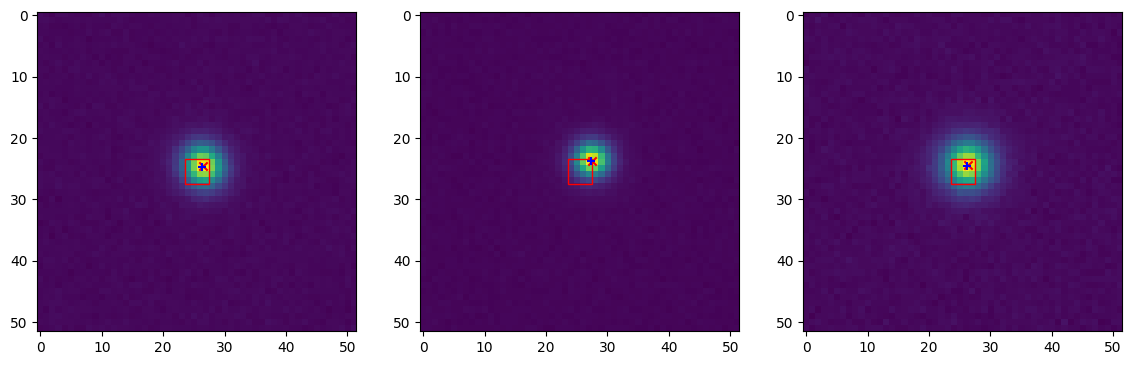

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(tbatch['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
truth_cat.n_sources.squeeze(), pred_cat.n_sources.squeeze()

(tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
         0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
         1, 0, 1, 1, 1, 0, 0, 0]),
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
         0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
         1, 0, 1, 1, 1, 0, 0, 0]))

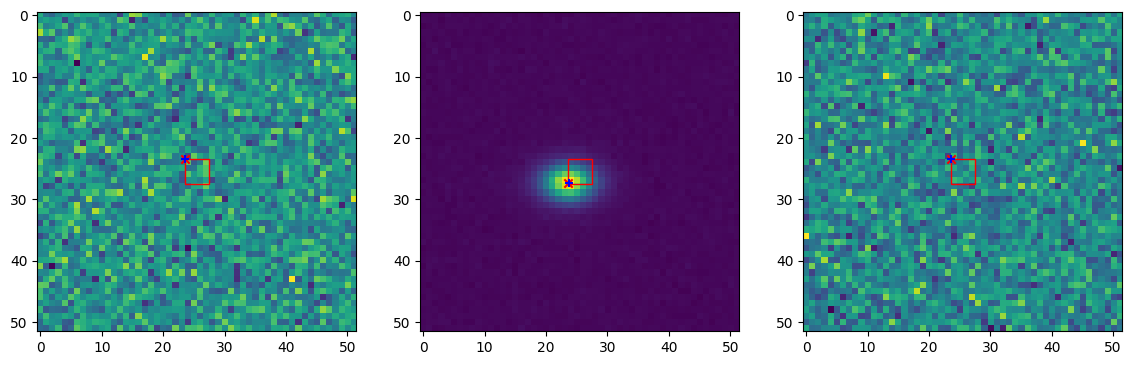

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(vbatch['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Varying flux but always bright sources

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

catsim_table = catsim_table[catsim_table['i_ab']<23.0]
n_samples = 128 * 11

len(catsim_table)

33051

In [ ]:
dataset = generate_dataset(n_samples, catsim_table, all_star_mags, 0.6, 1, psf, slen=4, bp=24, max_shift=0.5, galaxy_prob=1.0) # hack

100%|██████████| 1408/1408 [00:07<00:00, 187.69it/s]


ii tensor([0.7909, 0.8447])
ii tensor([0.2623, 0.3903])
ii tensor([0., 0.])


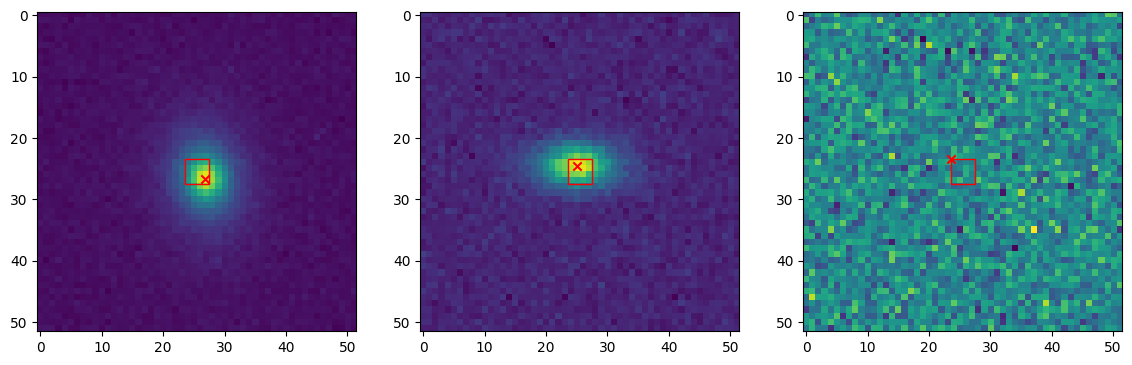

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = 128*10
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_single_bright_on_and_off.pt")
torch.save(val_ds, "val_ds_single_bright_on_and_off.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_single_bright_on_and_off.pt", 128 * 10, slen=4)
validation_dataset = SavedGalsimBlends("val_ds_single_bright_on_and_off.pt", 128 * 1, slen=4)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(100), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   5%|▌         | 5/100 [00:02<00:47,  2.00it/s]

epoch: 4 ,training_loss:  0.2414756625890732
epoch: 4 ,counter_training_loss:  0.1711803689599037
epoch: 4 ,counter_locs_loss:  0.0702952940016985


epoch::  10%|█         | 10/100 [00:05<00:39,  2.26it/s]

epoch: 9 ,training_loss:  -0.05967628341168165
epoch: 9 ,counter_training_loss:  0.132561157643795
epoch: 9 ,counter_locs_loss:  -0.1922374449670315


epoch::  15%|█▌        | 15/100 [00:07<00:37,  2.29it/s]

epoch: 14 ,training_loss:  -0.3021540090441704
epoch: 14 ,counter_training_loss:  0.10913941413164138
epoch: 14 ,counter_locs_loss:  -0.41129341423511506


epoch::  20%|██        | 20/100 [00:09<00:35,  2.26it/s]

epoch: 19 ,training_loss:  -0.5004516631364823
epoch: 19 ,counter_training_loss:  0.0878465712070465
epoch: 19 ,counter_locs_loss:  -0.5882982343435288


epoch::  25%|██▌       | 25/100 [00:11<00:32,  2.29it/s]

epoch: 24 ,training_loss:  -0.6883766531944275
epoch: 24 ,counter_training_loss:  0.06886546611785889
epoch: 24 ,counter_locs_loss:  -0.7572421371936798


epoch::  30%|███       | 30/100 [00:13<00:30,  2.29it/s]

epoch: 29 ,training_loss:  -0.8657224237918854
epoch: 29 ,counter_training_loss:  0.05558917298913002
epoch: 29 ,counter_locs_loss:  -0.9213116228580475


epoch::  35%|███▌      | 35/100 [00:16<00:30,  2.12it/s]

epoch: 34 ,training_loss:  -1.0029037535190581
epoch: 34 ,counter_training_loss:  0.049109331145882604
epoch: 34 ,counter_locs_loss:  -1.0520130753517152


epoch::  40%|████      | 40/100 [00:18<00:26,  2.25it/s]

epoch: 39 ,training_loss:  -1.047949594259262
epoch: 39 ,counter_training_loss:  0.04347031638026237
epoch: 39 ,counter_locs_loss:  -1.0914199113845826


epoch::  45%|████▌     | 45/100 [00:20<00:24,  2.27it/s]

epoch: 44 ,training_loss:  -1.0225146412849426
epoch: 44 ,counter_training_loss:  0.03713942840695381
epoch: 44 ,counter_locs_loss:  -1.0596540570259094


epoch::  50%|█████     | 50/100 [00:22<00:21,  2.28it/s]

epoch: 49 ,training_loss:  -1.1674783945083618
epoch: 49 ,counter_training_loss:  0.032886039651930335
epoch: 49 ,counter_locs_loss:  -1.2003644347190856


epoch::  55%|█████▌    | 55/100 [00:25<00:19,  2.28it/s]

epoch: 54 ,training_loss:  -1.3112807273864746
epoch: 54 ,counter_training_loss:  0.029432578943669796
epoch: 54 ,counter_locs_loss:  -1.3407133221626282


epoch::  60%|██████    | 60/100 [00:27<00:17,  2.27it/s]

epoch: 59 ,training_loss:  -1.3258615851402282
epoch: 59 ,counter_training_loss:  0.026909316331148146
epoch: 59 ,counter_locs_loss:  -1.3527708888053893


epoch::  65%|██████▌   | 65/100 [00:29<00:15,  2.28it/s]

epoch: 64 ,training_loss:  -1.2981269359588623
epoch: 64 ,counter_training_loss:  0.027749808505177498
epoch: 64 ,counter_locs_loss:  -1.3258767127990723


epoch::  70%|███████   | 70/100 [00:31<00:13,  2.29it/s]

epoch: 69 ,training_loss:  -1.48206684589386
epoch: 69 ,counter_training_loss:  0.02319525144994259
epoch: 69 ,counter_locs_loss:  -1.5052621364593506


epoch::  75%|███████▌  | 75/100 [00:33<00:11,  2.27it/s]

epoch: 74 ,training_loss:  -1.4519721627235413
epoch: 74 ,counter_training_loss:  0.020643060095608234
epoch: 74 ,counter_locs_loss:  -1.4726152181625367


epoch::  80%|████████  | 80/100 [00:36<00:08,  2.27it/s]

epoch: 79 ,training_loss:  -1.5226815223693848
epoch: 79 ,counter_training_loss:  0.019041584432125093
epoch: 79 ,counter_locs_loss:  -1.541723108291626


epoch::  85%|████████▌ | 85/100 [00:38<00:06,  2.25it/s]

epoch: 84 ,training_loss:  -1.4310878217220306
epoch: 84 ,counter_training_loss:  0.017611282970756294
epoch: 84 ,counter_locs_loss:  -1.4486991107463836


epoch::  90%|█████████ | 90/100 [00:40<00:04,  2.27it/s]

epoch: 89 ,training_loss:  -1.2292835116386414
epoch: 89 ,counter_training_loss:  0.01826175432652235
epoch: 89 ,counter_locs_loss:  -1.247545301914215


epoch::  95%|█████████▌| 95/100 [00:42<00:02,  2.26it/s]

epoch: 94 ,training_loss:  -1.419968193769455
epoch: 94 ,counter_training_loss:  0.015037308819592
epoch: 94 ,counter_locs_loss:  -1.43500554561615


epoch:: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]

epoch: 99 ,training_loss:  -1.482895839214325
epoch: 99 ,counter_training_loss:  0.013912619650363922
epoch: 99 ,counter_locs_loss:  -1.4968084573745728


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
truth_cat.n_sources.squeeze(),pred_cat.n_sources.squeeze() # the same
assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

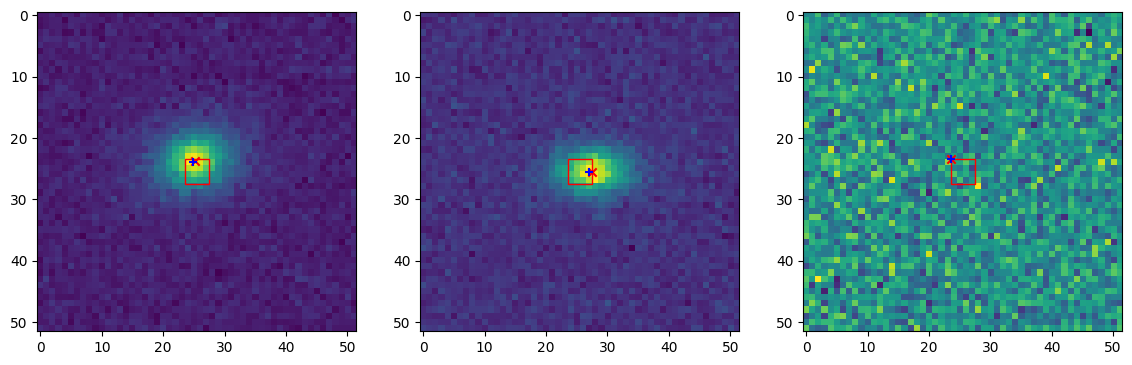

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
truth_cat.n_sources.squeeze(), pred_cat.n_sources.squeeze()

(tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 1]),
 tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 1]))

tensor(24.8403) tensor(25.8380) tensor(24.5363) tensor(25.6647)
tensor(24.6960) tensor(26.5742) tensor(24.4532) tensor(26.3024)
tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)


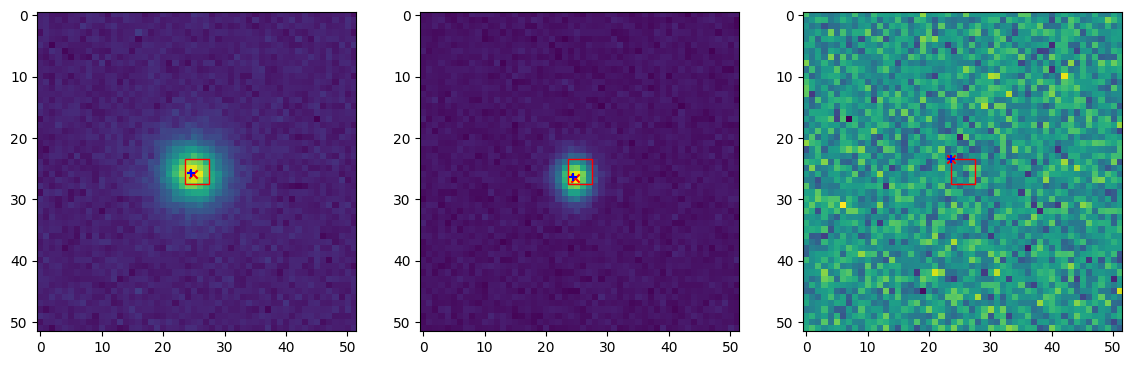

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(vbatch['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    print(x1,y1,x2,y2)

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Dim and bright sources (< 26 magnitude); still single tile per image

For this case we are able to get mixed results for both the training and validation set; where training set does better than validation (for counts).

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 256 * 11

new_table = catsim_table[catsim_table['i_ab'] < 26 ]

len(new_table)

312522

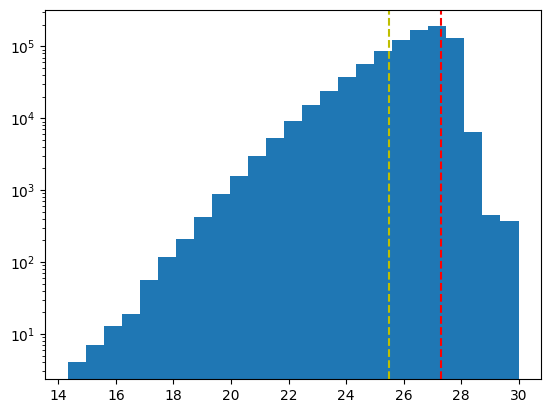

In [ ]:
plt.hist(catsim_table['i_ab'], bins=25)
plt.axvline(27.3, ls='--', color='r')
plt.axvline(25.5, ls='--', color='y')
plt.yscale('log')

In [ ]:
dataset = generate_dataset(n_samples, new_table, all_star_mags, 0.7, 1, psf, slen=4, bp=24, max_shift=0.5, galaxy_prob=1.0) # hack
dataset['n_sources'].sum()

  0%|          | 0/2816 [00:00<?, ?it/s]

100%|██████████| 2816/2816 [00:14<00:00, 194.96it/s]


tensor(1483)

ii tensor([0.2792, 0.9656])
ii tensor([0.0060, 0.2344])
ii tensor([0.2096, 0.1857])
ii tensor([0.0063, 0.2851])
ii tensor([0.3207, 0.2191])
ii tensor([0.0924, 0.2477])


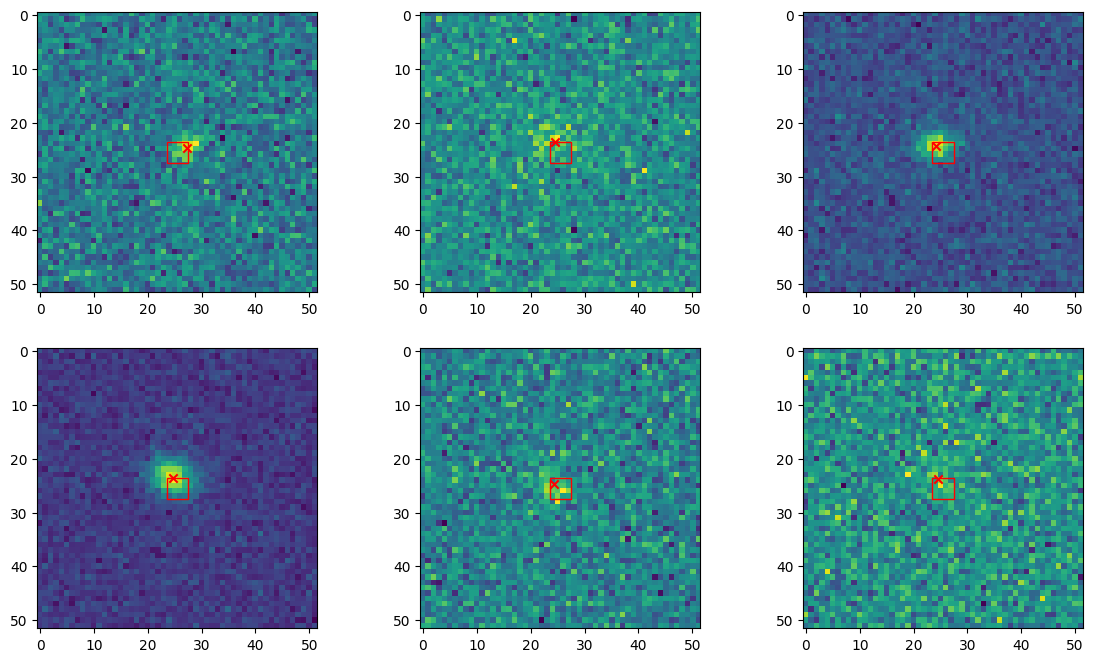

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = int(n_samples * 10 / 11)
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_single_bright_on_and_off.pt")
torch.save(val_ds, "val_ds_single_bright_on_and_off.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_single_bright_on_and_off.pt", n_samples * 10 // 11, slen=4)
validation_dataset = SavedGalsimBlends("val_ds_single_bright_on_and_off.pt", n_samples // 11, slen=4)

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(200), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   2%|▎         | 5/200 [00:04<02:52,  1.13it/s]

epoch: 4 ,training_loss:  0.07609855597838759
epoch: 4 ,counter_training_loss:  0.14306913428008555
epoch: 4 ,counter_locs_loss:  -0.066970578674227


epoch::   5%|▌         | 10/200 [00:08<02:50,  1.11it/s]

epoch: 9 ,training_loss:  -0.4215331733226776
epoch: 9 ,counter_training_loss:  0.11158586703240872
epoch: 9 ,counter_locs_loss:  -0.5331190407276154


epoch::   8%|▊         | 15/200 [00:13<02:46,  1.11it/s]

epoch: 14 ,training_loss:  -0.8624111890792847
epoch: 14 ,counter_training_loss:  0.07153867427259683
epoch: 14 ,counter_locs_loss:  -0.9339498400688171


epoch::  10%|█         | 20/200 [00:17<02:41,  1.11it/s]

epoch: 19 ,training_loss:  -1.1484521746635437
epoch: 19 ,counter_training_loss:  0.05351209361106157
epoch: 19 ,counter_locs_loss:  -1.2019642770290375


epoch::  12%|█▎        | 25/200 [00:22<02:35,  1.12it/s]

epoch: 24 ,training_loss:  -1.0660488158464432
epoch: 24 ,counter_training_loss:  0.06246023550629616
epoch: 24 ,counter_locs_loss:  -1.1285090744495392


epoch::  15%|█▌        | 30/200 [00:26<02:31,  1.12it/s]

epoch: 29 ,training_loss:  -1.316692727804184
epoch: 29 ,counter_training_loss:  0.03878533346578479
epoch: 29 ,counter_locs_loss:  -1.3554780602455139


epoch::  18%|█▊        | 35/200 [00:31<02:28,  1.11it/s]

epoch: 34 ,training_loss:  -1.4968904733657837
epoch: 34 ,counter_training_loss:  0.028925154637545348
epoch: 34 ,counter_locs_loss:  -1.525815635919571


epoch::  20%|██        | 40/200 [00:35<02:22,  1.12it/s]

epoch: 39 ,training_loss:  -1.4444324016571044
epoch: 39 ,counter_training_loss:  0.025374103616923094
epoch: 39 ,counter_locs_loss:  -1.4698065221309662


epoch::  22%|██▎       | 45/200 [00:40<02:30,  1.03it/s]

epoch: 44 ,training_loss:  -1.6207895159721375
epoch: 44 ,counter_training_loss:  0.021410433622077108
epoch: 44 ,counter_locs_loss:  -1.6421999424695968


epoch::  25%|██▌       | 50/200 [00:45<02:16,  1.10it/s]

epoch: 49 ,training_loss:  -1.5864034682512282
epoch: 49 ,counter_training_loss:  0.020192497316747902
epoch: 49 ,counter_locs_loss:  -1.6065959870815276


epoch::  28%|██▊       | 55/200 [00:49<02:10,  1.11it/s]

epoch: 54 ,training_loss:  -1.703861939907074
epoch: 54 ,counter_training_loss:  0.01816475410014391
epoch: 54 ,counter_locs_loss:  -1.7220267325639724


epoch::  30%|███       | 60/200 [00:54<02:05,  1.12it/s]

epoch: 59 ,training_loss:  -1.7585370153188706
epoch: 59 ,counter_training_loss:  0.015999946976080537
epoch: 59 ,counter_locs_loss:  -1.7745369672775269


epoch::  32%|███▎      | 65/200 [00:58<02:00,  1.12it/s]

epoch: 64 ,training_loss:  -1.8323396265506744
epoch: 64 ,counter_training_loss:  0.0137139106169343
epoch: 64 ,counter_locs_loss:  -1.846053546667099


epoch::  35%|███▌      | 70/200 [01:03<01:56,  1.11it/s]

epoch: 69 ,training_loss:  -1.8437344431877136
epoch: 69 ,counter_training_loss:  0.013623713934794068
epoch: 69 ,counter_locs_loss:  -1.857358157634735


epoch::  38%|███▊      | 75/200 [01:07<01:52,  1.11it/s]

epoch: 74 ,training_loss:  -1.7622173964977264
epoch: 74 ,counter_training_loss:  0.01606116848997772
epoch: 74 ,counter_locs_loss:  -1.778278547525406


epoch::  40%|████      | 80/200 [01:12<01:47,  1.11it/s]

epoch: 79 ,training_loss:  -2.002299588918686
epoch: 79 ,counter_training_loss:  0.009895306848920881
epoch: 79 ,counter_locs_loss:  -2.012194871902466


epoch::  42%|████▎     | 85/200 [01:16<01:43,  1.11it/s]

epoch: 84 ,training_loss:  -1.6990097522735597
epoch: 84 ,counter_training_loss:  0.017391240526922046
epoch: 84 ,counter_locs_loss:  -1.716400970518589


epoch::  45%|████▌     | 90/200 [01:21<01:39,  1.11it/s]

epoch: 89 ,training_loss:  -2.0972998321056364
epoch: 89 ,counter_training_loss:  0.008234113268554211
epoch: 89 ,counter_locs_loss:  -2.1055339515209197


epoch::  48%|████▊     | 95/200 [01:25<01:34,  1.11it/s]

epoch: 94 ,training_loss:  -1.8525389015674592
epoch: 94 ,counter_training_loss:  0.007938185892999172
epoch: 94 ,counter_locs_loss:  -1.8604770481586457


epoch::  50%|█████     | 100/200 [01:30<01:30,  1.11it/s]

epoch: 99 ,training_loss:  -1.8139227390289308
epoch: 99 ,counter_training_loss:  0.012398460716940462
epoch: 99 ,counter_locs_loss:  -1.826321190595627


epoch::  52%|█████▎    | 105/200 [01:34<01:25,  1.11it/s]

epoch: 104 ,training_loss:  -2.1716817140579225
epoch: 104 ,counter_training_loss:  0.007073535490781069
epoch: 104 ,counter_locs_loss:  -2.1787552714347838


epoch::  55%|█████▌    | 110/200 [01:39<01:21,  1.11it/s]

epoch: 109 ,training_loss:  -2.137217092514038
epoch: 109 ,counter_training_loss:  0.007671628915704787
epoch: 109 ,counter_locs_loss:  -2.1448887526988982


epoch::  57%|█████▊    | 115/200 [01:43<01:16,  1.12it/s]

epoch: 114 ,training_loss:  -2.1532425820827483
epoch: 114 ,counter_training_loss:  0.00566965751349926
epoch: 114 ,counter_locs_loss:  -2.1589122116565704


epoch::  60%|██████    | 120/200 [01:48<01:11,  1.11it/s]

epoch: 119 ,training_loss:  -2.0141615688800814
epoch: 119 ,counter_training_loss:  0.0151921012904495
epoch: 119 ,counter_locs_loss:  -2.029353696107864


epoch::  62%|██████▎   | 125/200 [01:52<01:07,  1.12it/s]

epoch: 124 ,training_loss:  -2.2499121189117433
epoch: 124 ,counter_training_loss:  0.006633556168526411
epoch: 124 ,counter_locs_loss:  -2.2565457046031954


epoch::  65%|██████▌   | 130/200 [01:57<01:02,  1.12it/s]

epoch: 129 ,training_loss:  -2.096872314810753
epoch: 129 ,counter_training_loss:  0.007272283872589469
epoch: 129 ,counter_locs_loss:  -2.104144576191902


epoch::  68%|██████▊   | 135/200 [02:01<00:58,  1.11it/s]

epoch: 134 ,training_loss:  -2.198296719789505
epoch: 134 ,counter_training_loss:  0.00769641965162009
epoch: 134 ,counter_locs_loss:  -2.2059931218624116


epoch::  70%|███████   | 140/200 [02:06<00:57,  1.04it/s]

epoch: 139 ,training_loss:  -2.1467863589525225
epoch: 139 ,counter_training_loss:  0.010361644672229886
epoch: 139 ,counter_locs_loss:  -2.1571480572223662


epoch::  72%|███████▎  | 145/200 [02:10<00:50,  1.10it/s]

epoch: 144 ,training_loss:  -2.11587655544281
epoch: 144 ,counter_training_loss:  0.00923482202924788
epoch: 144 ,counter_locs_loss:  -2.125111299753189


epoch::  75%|███████▌  | 150/200 [02:15<00:45,  1.11it/s]

epoch: 149 ,training_loss:  -2.286901366710663
epoch: 149 ,counter_training_loss:  0.007019611087162048
epoch: 149 ,counter_locs_loss:  -2.293920934200287


epoch::  78%|███████▊  | 155/200 [02:19<00:40,  1.11it/s]

epoch: 154 ,training_loss:  -2.1966556787490843
epoch: 154 ,counter_training_loss:  0.006066277530044318
epoch: 154 ,counter_locs_loss:  -2.202722007036209


epoch::  80%|████████  | 160/200 [02:24<00:35,  1.12it/s]

epoch: 159 ,training_loss:  -2.2921945095062255
epoch: 159 ,counter_training_loss:  0.006521772104315459
epoch: 159 ,counter_locs_loss:  -2.2987162709236144


epoch::  82%|████████▎ | 165/200 [02:28<00:31,  1.11it/s]

epoch: 164 ,training_loss:  -2.1483350843191147
epoch: 164 ,counter_training_loss:  0.008136542537249625
epoch: 164 ,counter_locs_loss:  -2.1564716681838036


epoch::  85%|████████▌ | 170/200 [02:33<00:26,  1.11it/s]

epoch: 169 ,training_loss:  -2.132430762052536
epoch: 169 ,counter_training_loss:  0.007382892339956015
epoch: 169 ,counter_locs_loss:  -2.1398135483264924


epoch::  88%|████████▊ | 175/200 [02:37<00:22,  1.11it/s]

epoch: 174 ,training_loss:  -2.1805452167987824
epoch: 174 ,counter_training_loss:  0.006753468990791589
epoch: 174 ,counter_locs_loss:  -2.187298682332039


epoch::  90%|█████████ | 180/200 [02:42<00:18,  1.11it/s]

epoch: 179 ,training_loss:  -2.3844483375549315
epoch: 179 ,counter_training_loss:  0.004450583085417748
epoch: 179 ,counter_locs_loss:  -2.388898915052414


epoch::  92%|█████████▎| 185/200 [02:46<00:13,  1.11it/s]

epoch: 184 ,training_loss:  -2.272353208065033
epoch: 184 ,counter_training_loss:  0.006129212235100568
epoch: 184 ,counter_locs_loss:  -2.2784824132919312


epoch::  95%|█████████▌| 190/200 [02:51<00:08,  1.11it/s]

epoch: 189 ,training_loss:  -2.3676229536533357
epoch: 189 ,counter_training_loss:  0.0048418156453408304
epoch: 189 ,counter_locs_loss:  -2.3724647641181944


epoch::  98%|█████████▊| 195/200 [02:55<00:04,  1.11it/s]

epoch: 194 ,training_loss:  -2.350431594252586
epoch: 194 ,counter_training_loss:  0.005188314965926111
epoch: 194 ,counter_locs_loss:  -2.3556198358535765


epoch:: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s]

epoch: 199 ,training_loss:  -2.4232427000999452
epoch: 199 ,counter_training_loss:  0.005013961694203317
epoch: 199 ,counter_locs_loss:  -2.4282566905021667


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.squeeze()
n_sources2 = pred_cat.n_sources.squeeze() 
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2

# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(1.)


(tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 0, 1, 0, 0, 0]),
 tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
         1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 0, 1, 0, 0, 0]))

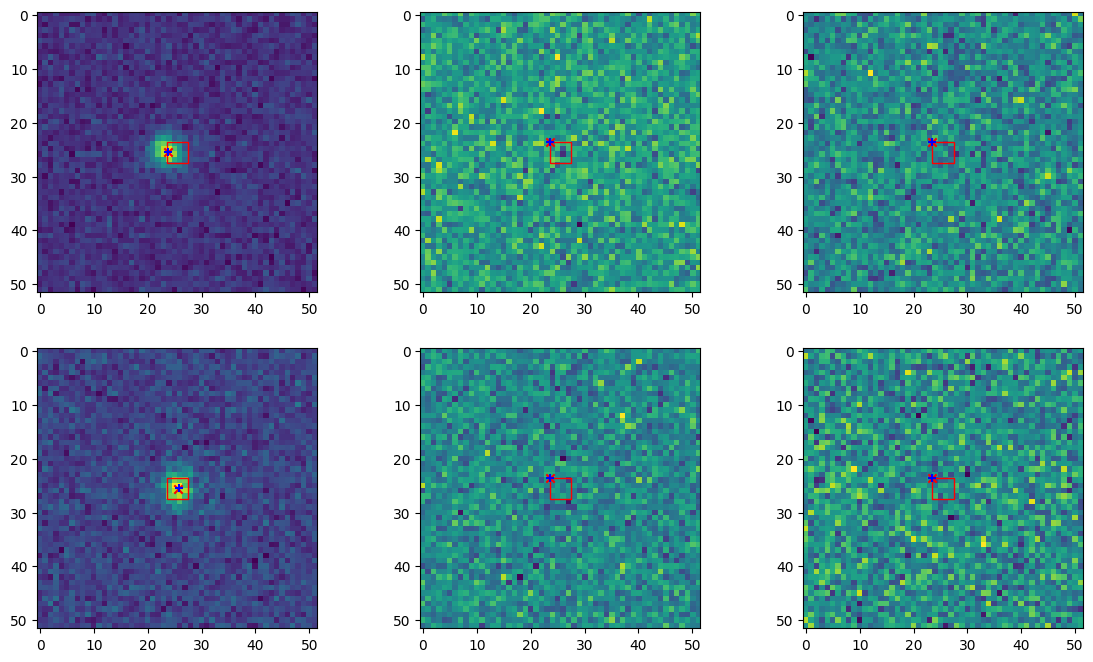

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.squeeze()
n_sources2 = pred_cat.n_sources.squeeze() 
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1, n_sources2

tensor(0.9922)


(tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
         0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 0, 1]),
 tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
         0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 0, 1]))

tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)
tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)
tensor(24.7591) tensor(23.7853) tensor(25.0276) tensor(23.7454)
tensor(26.4616) tensor(24.5916) tensor(26.6525) tensor(24.7252)
tensor(27.0441) tensor(25.9973) tensor(27.2894) tensor(25.6812)
tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)


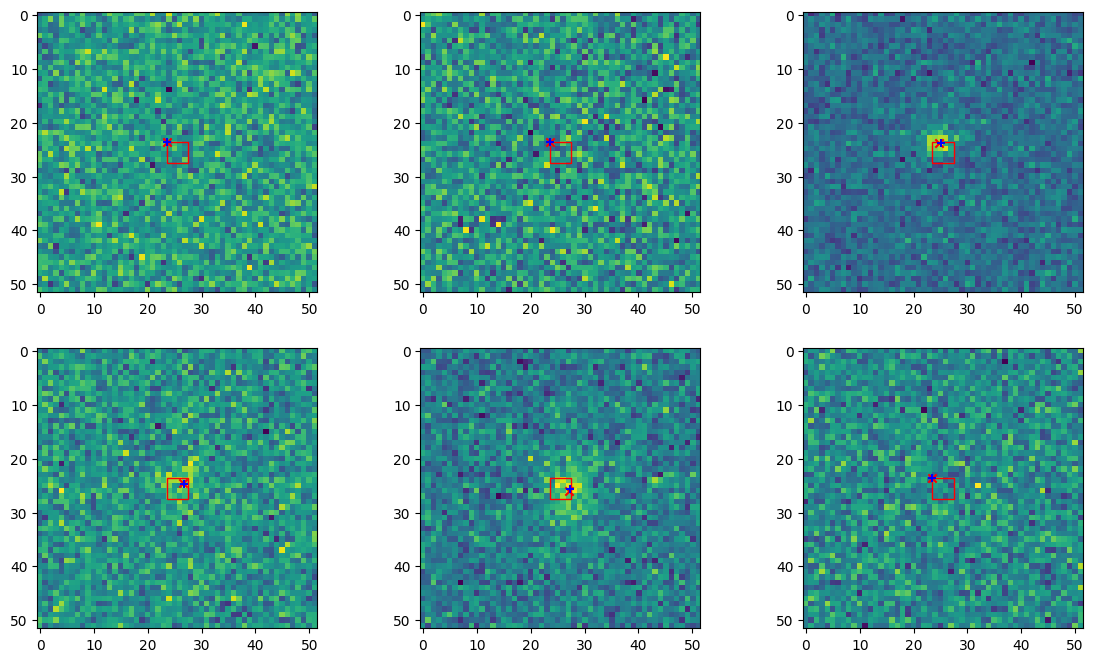

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    print(x1,y1,x2,y2)

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Dim and bright sources; one tile per image; < 27.3 mag (i.e. full distribution of mags)

**Notes:** We can increase the size of the dataset until they are enough detectable galaxies so that the model is trained well. Actually we get pretty good accuracy of counts and reasonable centroid prediction (see below).

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 512 * 11

new_table = catsim_table[catsim_table['i_ab'] < 27.3 ]

len(new_table)

666475

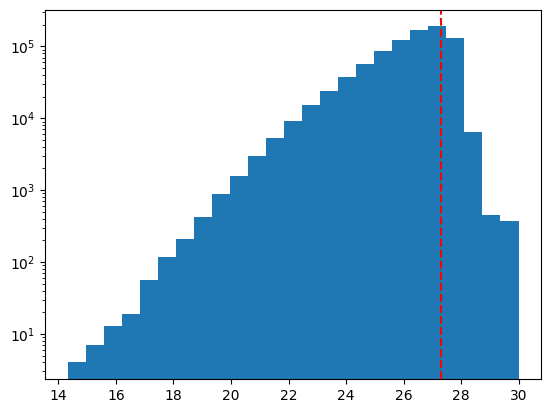

In [ ]:
plt.hist(catsim_table['i_ab'], bins=25)
plt.axvline(27.3, ls='--', color='r')
plt.yscale('log')

In [ ]:
dataset = generate_dataset(n_samples, new_table, all_star_mags, 0.7, 1, psf, slen=4, bp=24, max_shift=0.5, galaxy_prob=1.0)
dataset['n_sources'].sum()

  0%|          | 0/5632 [00:00<?, ?it/s]

100%|██████████| 5632/5632 [00:34<00:00, 163.20it/s]


tensor(2872)

ii tensor([0., 0.])
ii tensor([0.5017, 0.4596])
ii tensor([0.7302, 0.2892])
ii tensor([0.3604, 0.4663])
ii tensor([0., 0.])
ii tensor([0., 0.])


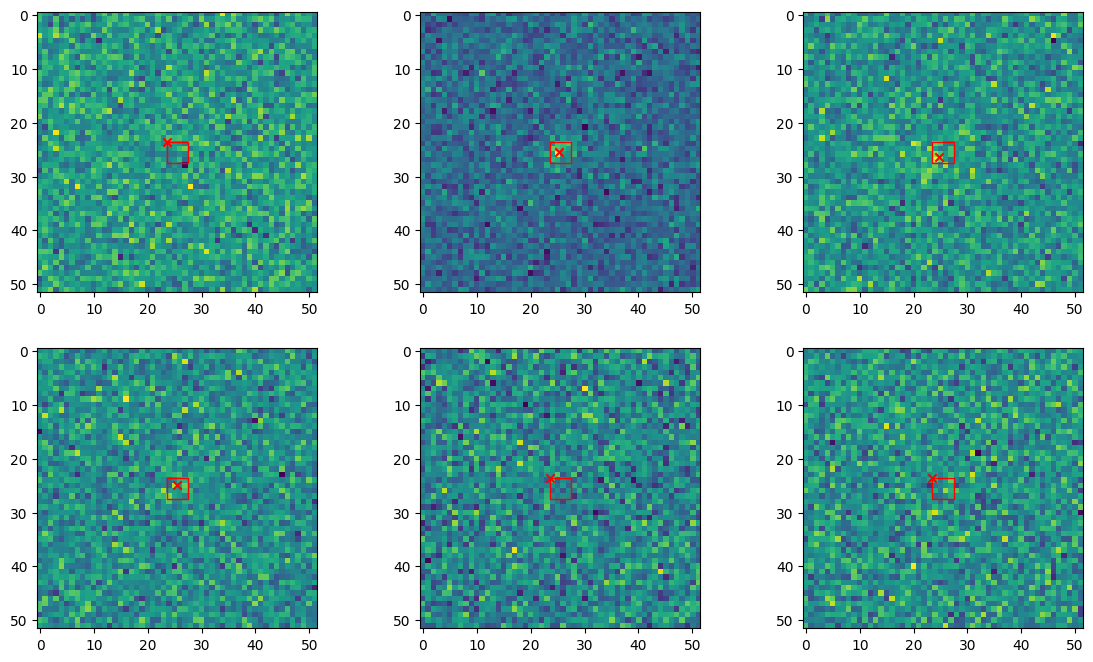

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = int(n_samples * 10 / 11)
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_single_bright_on_and_off.pt")
torch.save(val_ds, "val_ds_single_bright_on_and_off.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_single_bright_on_and_off.pt", n_samples * 10 // 11, slen=4)
validation_dataset = SavedGalsimBlends("val_ds_single_bright_on_and_off.pt", n_samples // 11, slen=4)
len(train_dataset)

5120

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(200), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 10 == 9:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   5%|▌         | 10/200 [00:18<05:41,  1.80s/it]

epoch: 9 ,training_loss:  -0.421321162302047
epoch: 9 ,counter_training_loss:  0.1556535182520747
epoch: 9 ,counter_locs_loss:  -0.5769746832549572


epoch::  10%|█         | 20/200 [00:36<05:27,  1.82s/it]

epoch: 19 ,training_loss:  -0.8307808205485344
epoch: 19 ,counter_training_loss:  0.11308409105986357
epoch: 19 ,counter_locs_loss:  -0.9438649222254754


epoch::  15%|█▌        | 30/200 [00:54<04:58,  1.76s/it]

epoch: 29 ,training_loss:  -1.1174161244183778
epoch: 29 ,counter_training_loss:  0.08546279491856694
epoch: 29 ,counter_locs_loss:  -1.2028789095580579


epoch::  20%|██        | 40/200 [01:11<04:41,  1.76s/it]

epoch: 39 ,training_loss:  -1.5098015308380126
epoch: 39 ,counter_training_loss:  0.05363168055191636
epoch: 39 ,counter_locs_loss:  -1.5634332418441772


epoch::  25%|██▌       | 50/200 [01:29<04:23,  1.76s/it]

epoch: 49 ,training_loss:  -1.7038047343492508
epoch: 49 ,counter_training_loss:  0.03669316051527858
epoch: 49 ,counter_locs_loss:  -1.7404979079961778


epoch::  30%|███       | 60/200 [01:46<04:05,  1.76s/it]

epoch: 59 ,training_loss:  -1.8377628535032273
epoch: 59 ,counter_training_loss:  0.028116781963035464
epoch: 59 ,counter_locs_loss:  -1.8658796399831772


epoch::  35%|███▌      | 70/200 [02:04<03:58,  1.83s/it]

epoch: 69 ,training_loss:  -1.9286286324262618
epoch: 69 ,counter_training_loss:  0.025008219201117753
epoch: 69 ,counter_locs_loss:  -1.9536368757486344


epoch::  40%|████      | 80/200 [02:22<03:31,  1.76s/it]

epoch: 79 ,training_loss:  -2.048866632580757
epoch: 79 ,counter_training_loss:  0.02025383261498064
epoch: 79 ,counter_locs_loss:  -2.069120478630066


epoch::  45%|████▌     | 90/200 [02:39<03:13,  1.76s/it]

epoch: 89 ,training_loss:  -2.0477886646986008
epoch: 89 ,counter_training_loss:  0.016184597089886666
epoch: 89 ,counter_locs_loss:  -2.0639732241630555


epoch::  50%|█████     | 100/200 [02:57<02:55,  1.75s/it]

epoch: 99 ,training_loss:  -2.071055841445923
epoch: 99 ,counter_training_loss:  0.015556737687438727
epoch: 99 ,counter_locs_loss:  -2.086612570285797


epoch::  55%|█████▌    | 110/200 [03:14<02:37,  1.75s/it]

epoch: 109 ,training_loss:  -2.1798466622829435
epoch: 109 ,counter_training_loss:  0.012825040682218968
epoch: 109 ,counter_locs_loss:  -2.1926717191934584


epoch::  60%|██████    | 120/200 [03:32<02:23,  1.79s/it]

epoch: 119 ,training_loss:  -2.2162254959344865
epoch: 119 ,counter_training_loss:  0.01134669192833826
epoch: 119 ,counter_locs_loss:  -2.2275722175836563


epoch::  65%|██████▌   | 130/200 [03:50<02:04,  1.78s/it]

epoch: 129 ,training_loss:  -2.2305915623903276
epoch: 129 ,counter_training_loss:  0.012402802635915578
epoch: 129 ,counter_locs_loss:  -2.24299436211586


epoch::  70%|███████   | 140/200 [04:08<01:45,  1.76s/it]

epoch: 139 ,training_loss:  -2.245714637637138
epoch: 139 ,counter_training_loss:  0.009863774594850837
epoch: 139 ,counter_locs_loss:  -2.25557841360569


epoch::  75%|███████▌  | 150/200 [04:25<01:28,  1.76s/it]

epoch: 149 ,training_loss:  -2.4243080049753187
epoch: 149 ,counter_training_loss:  0.006903647689614445
epoch: 149 ,counter_locs_loss:  -2.4312116712331773


epoch::  80%|████████  | 160/200 [04:43<01:10,  1.76s/it]

epoch: 159 ,training_loss:  -2.414892166852951
epoch: 159 ,counter_training_loss:  0.00877550029545091
epoch: 159 ,counter_locs_loss:  -2.423667702078819


epoch::  85%|████████▌ | 170/200 [05:01<00:53,  1.77s/it]

epoch: 169 ,training_loss:  -2.4468671530485153
epoch: 169 ,counter_training_loss:  0.008152637450257317
epoch: 169 ,counter_locs_loss:  -2.4550197809934615


epoch::  90%|█████████ | 180/200 [05:19<00:35,  1.78s/it]

epoch: 179 ,training_loss:  -2.5414573550224304
epoch: 179 ,counter_training_loss:  0.006896797302761115
epoch: 179 ,counter_locs_loss:  -2.5483541578054427


epoch::  95%|█████████▌| 190/200 [05:36<00:17,  1.77s/it]

epoch: 189 ,training_loss:  -2.465064811706543
epoch: 189 ,counter_training_loss:  0.005992364755365997
epoch: 189 ,counter_locs_loss:  -2.4710572719573975


epoch:: 100%|██████████| 200/200 [05:54<00:00,  1.77s/it]

epoch: 199 ,training_loss:  -2.514835986495018
epoch: 199 ,counter_training_loss:  0.00664047752507031
epoch: 199 ,counter_locs_loss:  -2.5214765042066576


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.squeeze()
n_sources2 = pred_cat.n_sources.squeeze() 
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2
# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(0.9766)


(tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
         1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 1, 0]),
 tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
         1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
         1, 0, 0, 1, 0, 0, 1, 0]))

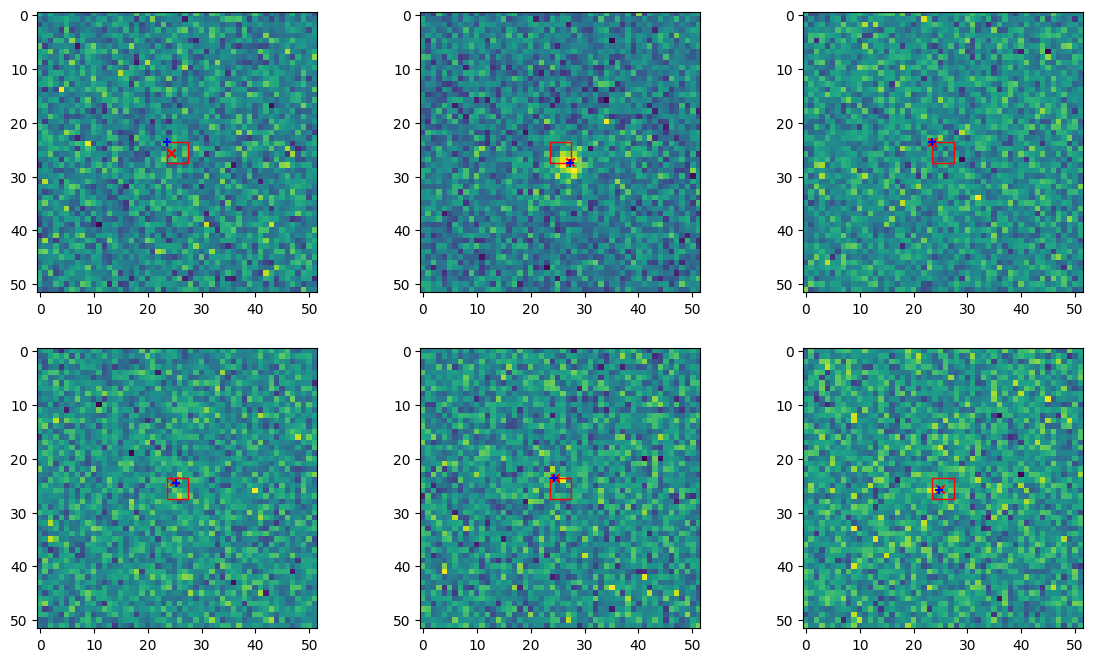

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.squeeze()
n_sources2 = pred_cat.n_sources.squeeze() 
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1, n_sources2

tensor(0.9375)


(tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 1, 0, 0, 1, 1, 0, 0]),
 tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
         1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
         0, 1, 0, 0, 1, 1, 0, 0]))

tensor(26.0858) tensor(23.5538) tensor(25.8574) tensor(24.4613)
tensor(25.5661) tensor(27.0092) tensor(25.2593) tensor(26.7060)
tensor(27.2440) tensor(24.4944) tensor(26.9396) tensor(24.8800)
tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)
tensor(23.5000) tensor(23.5000) tensor(23.5000) tensor(23.5000)
tensor(26.4694) tensor(24.0591) tensor(25.7540) tensor(25.1731)


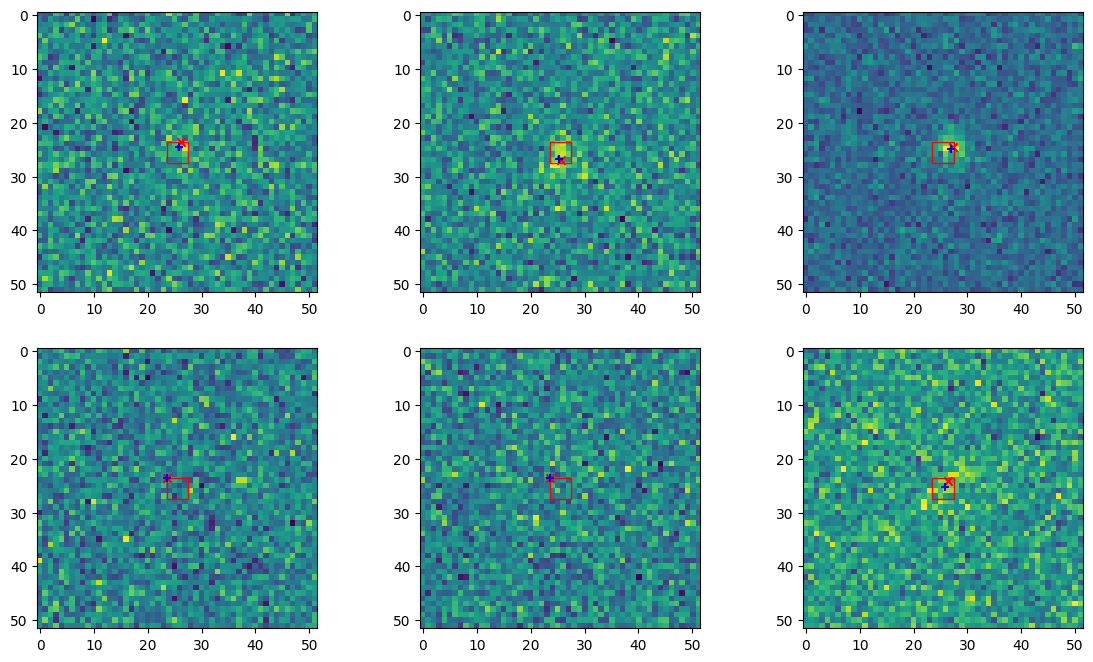

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx][0]
    plocs2 = pred_cat.to_full_params().plocs[idx][0]
    y1, x1 = plocs1 - 0.5 + 24
    y2, x2 = plocs2 - 0.5 + 24

    print(x1,y1,x2,y2)

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Bright sources; 4 tiles per image

**Notes:**  Performance is reduced because of highly blended sources; but we are able to train teh model successfully and find the sources that are isolated and sometimes multilpe ones reasonably

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 128 * 11

new_table = catsim_table[catsim_table['i_ab'] < 23 ]

len(new_table)

33051

In [ ]:
dataset = generate_dataset(n_samples, new_table, all_star_mags, 1.5, 4, psf, slen=8, bp=24, max_shift=0.5, galaxy_prob=1.0)
dataset['n_sources'].sum()

  0%|          | 0/1408 [00:00<?, ?it/s]

100%|██████████| 1408/1408 [00:16<00:00, 84.13it/s] 


tensor(2099)

In [ ]:
dataset['images'].shape

torch.Size([1408, 1, 56, 56])

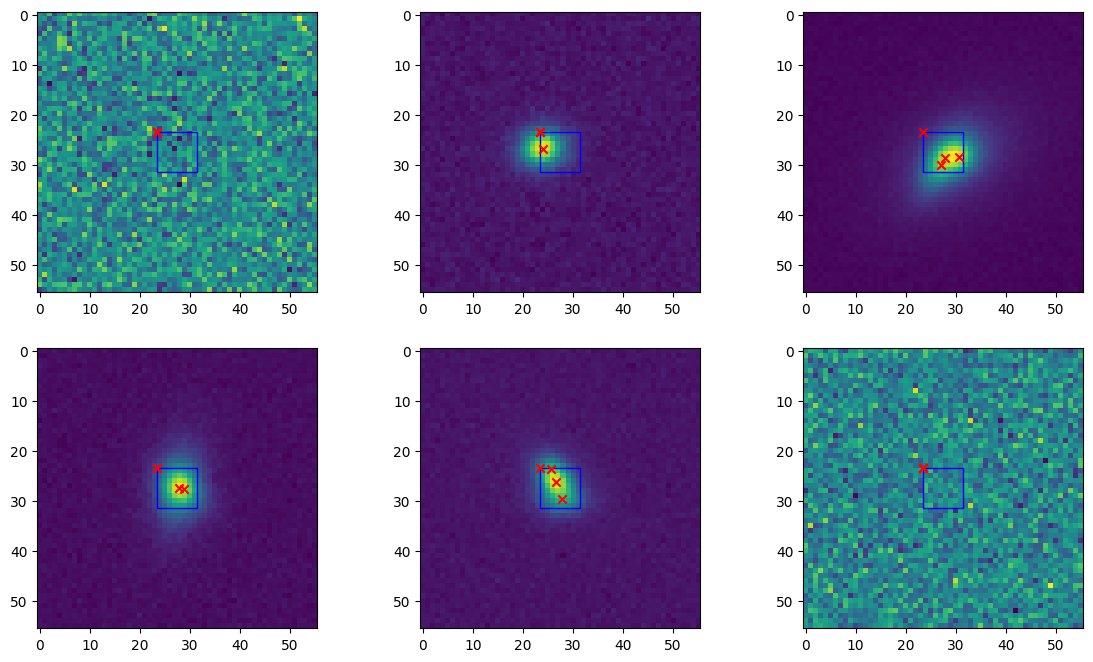

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = dataset['images'][idx][0]

    ax.imshow(np.log10(image))

    # square of 8 pixels centered
    rect = patches.Rectangle((27.5-4, 27.5-4), 8, 8, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = int(n_samples * 10 / 11)
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_4_tiles_bright.pt")
torch.save(val_ds, "val_ds_4_tiles_bright.pt")

In [ ]:
# plotting tiles 
from bliss.render_tiles import get_images_in_tiles
from einops import rearrange
tiled_images = get_images_in_tiles(train_ds['images'], 4, 52)
plotting_images = rearrange(tiled_images, 'b nth ntw 1 h w -> b (nth h) (ntw w)')
plotting_images.shape

torch.Size([1280, 104, 104])

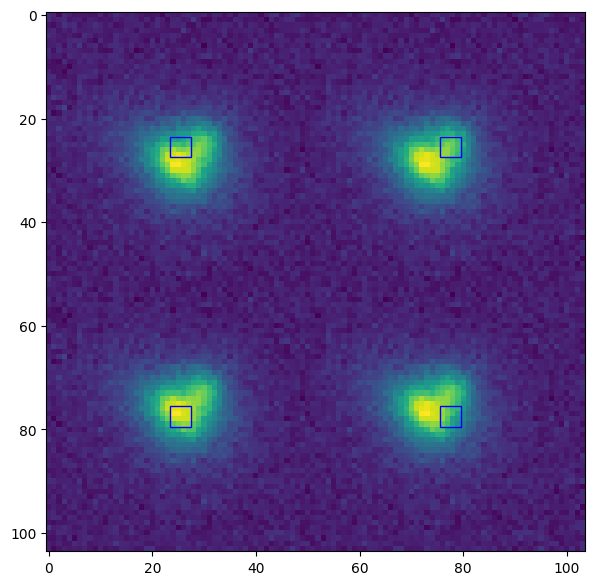

In [ ]:


fig, ax = plt.subplots(1, 1, figsize=(7,7))
idx = np.random.choice(range(1280))
ax.imshow(np.log10(plotting_images[idx]))

# square of 8 pixels centered
rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((25.5+52-2, 25.5+52-2), 4, 4, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((25.5+52-2, 25.5-2), 4, 4, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((25.5-2, 25.5+52-2), 4, 4, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_4_tiles_bright.pt", n_samples * 10 // 11, slen=8)
validation_dataset = SavedGalsimBlends("val_ds_4_tiles_bright.pt", n_samples // 11, slen=8)
len(train_dataset)

1280

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=128)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(200), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 10 == 9:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   0%|          | 0/200 [00:00<?, ?it/s]

epoch::   5%|▌         | 10/200 [00:10<03:09,  1.00it/s]

epoch: 9 ,training_loss:  0.6499023318290711
epoch: 9 ,counter_training_loss:  0.3708538383245468
epoch: 9 ,counter_locs_loss:  0.2790484830737114


epoch::  10%|█         | 20/200 [00:20<02:59,  1.00it/s]

epoch: 19 ,training_loss:  0.31790600568056104
epoch: 19 ,counter_training_loss:  0.2695005387067795
epoch: 19 ,counter_locs_loss:  0.04840546622872353


epoch::  15%|█▌        | 30/200 [00:30<02:50,  1.00s/it]

epoch: 29 ,training_loss:  0.05961036826483905
epoch: 29 ,counter_training_loss:  0.20971653014421462
epoch: 29 ,counter_locs_loss:  -0.15010616481304168


epoch::  20%|██        | 40/200 [00:40<02:40,  1.01s/it]

epoch: 39 ,training_loss:  -0.1425296261906624
epoch: 39 ,counter_training_loss:  0.1656612426042557
epoch: 39 ,counter_locs_loss:  -0.3081908725202084


epoch::  25%|██▌       | 50/200 [00:50<02:32,  1.02s/it]

epoch: 49 ,training_loss:  -0.318916604667902
epoch: 49 ,counter_training_loss:  0.1316715344786644
epoch: 49 ,counter_locs_loss:  -0.4505881488323212


epoch::  30%|███       | 60/200 [01:00<02:23,  1.02s/it]

epoch: 59 ,training_loss:  -0.4772229760885239
epoch: 59 ,counter_training_loss:  0.1106744334101677
epoch: 59 ,counter_locs_loss:  -0.5878974199295044


epoch::  35%|███▌      | 70/200 [01:10<02:13,  1.02s/it]

epoch: 69 ,training_loss:  -0.5726664893329143
epoch: 69 ,counter_training_loss:  0.09306278601288795
epoch: 69 ,counter_locs_loss:  -0.6657292827963829


epoch::  40%|████      | 80/200 [01:20<02:02,  1.02s/it]

epoch: 79 ,training_loss:  -0.6093373671174049
epoch: 79 ,counter_training_loss:  0.08540000766515732
epoch: 79 ,counter_locs_loss:  -0.69473737180233


epoch::  45%|████▌     | 90/200 [01:31<01:52,  1.02s/it]

epoch: 89 ,training_loss:  -0.756444339454174
epoch: 89 ,counter_training_loss:  0.07383027859032154
epoch: 89 ,counter_locs_loss:  -0.8302746266126633


epoch::  50%|█████     | 100/200 [01:41<01:42,  1.02s/it]

epoch: 99 ,training_loss:  -0.8348722338676453
epoch: 99 ,counter_training_loss:  0.06410323791205882
epoch: 99 ,counter_locs_loss:  -0.8989754498004914


epoch::  55%|█████▌    | 110/200 [01:51<01:31,  1.02s/it]

epoch: 109 ,training_loss:  -0.9181254267692566
epoch: 109 ,counter_training_loss:  0.05776800066232681
epoch: 109 ,counter_locs_loss:  -0.9758934736251831


epoch::  60%|██████    | 120/200 [02:01<01:21,  1.02s/it]

epoch: 119 ,training_loss:  -0.929317620396614
epoch: 119 ,counter_training_loss:  0.054375356249511245
epoch: 119 ,counter_locs_loss:  -0.9836929827928543


epoch::  65%|██████▌   | 130/200 [02:12<01:23,  1.19s/it]

epoch: 129 ,training_loss:  -1.0089168936014175
epoch: 129 ,counter_training_loss:  0.04870918914675713
epoch: 129 ,counter_locs_loss:  -1.0576260685920715


epoch::  70%|███████   | 140/200 [02:22<01:01,  1.03s/it]

epoch: 139 ,training_loss:  -1.0371368110179902
epoch: 139 ,counter_training_loss:  0.04426595829427242
epoch: 139 ,counter_locs_loss:  -1.0814027607440948


epoch::  75%|███████▌  | 150/200 [02:33<00:51,  1.03s/it]

epoch: 149 ,training_loss:  -1.1477867394685746
epoch: 149 ,counter_training_loss:  0.03693573269993067
epoch: 149 ,counter_locs_loss:  -1.1847224295139314


epoch::  80%|████████  | 160/200 [02:43<00:41,  1.03s/it]

epoch: 159 ,training_loss:  -1.1711645722389221
epoch: 159 ,counter_training_loss:  0.0372819684445858
epoch: 159 ,counter_locs_loss:  -1.2084465086460114


epoch::  85%|████████▌ | 170/200 [02:53<00:30,  1.03s/it]

epoch: 169 ,training_loss:  -1.2071774840354919
epoch: 169 ,counter_training_loss:  0.031533132307231426
epoch: 169 ,counter_locs_loss:  -1.238710618019104


epoch::  90%|█████████ | 180/200 [03:04<00:20,  1.02s/it]

epoch: 179 ,training_loss:  -1.288795816898346
epoch: 179 ,counter_training_loss:  0.028364049270749092
epoch: 179 ,counter_locs_loss:  -1.3171598494052887


epoch::  95%|█████████▌| 190/200 [03:14<00:10,  1.02s/it]

epoch: 189 ,training_loss:  -1.27944256067276
epoch: 189 ,counter_training_loss:  0.028252154216170312
epoch: 189 ,counter_locs_loss:  -1.3076947331428528


epoch:: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]

epoch: 199 ,training_loss:  -1.273086941242218
epoch: 199 ,counter_training_loss:  0.0293682586401701
epoch: 199 ,counter_locs_loss:  -1.302455186843872


In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.sum(dim=(-1, -2))
n_sources2 = pred_cat.n_sources.sum(dim=(-1, -2))
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2
# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(0.3672)


(tensor([1, 1, 2, 2, 3, 0, 0, 0, 2, 2, 1, 0, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 3, 3,
         1, 2, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 2,
         2, 4, 2, 2, 0, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 1, 2, 0, 2, 3, 0, 1, 2, 1,
         1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1,
         1, 2, 2, 1, 2, 0, 3, 3, 2, 1, 2, 0, 2, 1, 1, 1, 2, 1, 0, 0, 3, 1, 1, 2,
         1, 0, 1, 2, 1, 1, 0, 0]),
 tensor([0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 1,
         0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         1, 2, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 3, 2, 1, 1, 3, 0, 1, 1, 0, 1, 1, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 0]))

In [ ]:
for ii in range(2):
    print(ii)

0
1


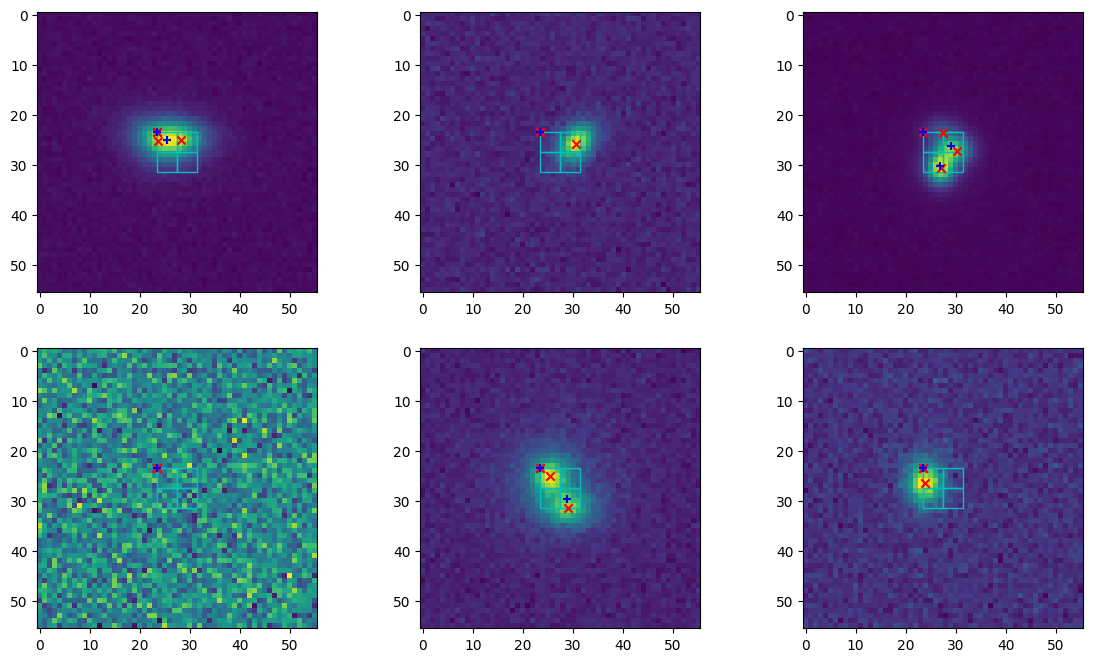

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # plot the 4 tiles
    for ii in range(2):
        for jj in range(2):
            rect = patches.Rectangle((27.5-4+ii*4, 27.5-4+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
            ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx] - 0.5 + 24
    plocs2 = pred_cat.to_full_params().plocs[idx] - 0.5 + 24
    y1 = plocs1[:, 0]
    x1 = plocs1[:, 1]
    y2 = plocs2[:, 0]
    x2 = plocs2[:, 1]

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.sum(dim=(-1, -2))
n_sources2 = pred_cat.n_sources.sum(dim=(-1, -2))
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2
# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(0.4219)


(tensor([1, 0, 0, 3, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 0, 1, 2, 3, 2, 3, 1, 1, 1, 1,
         0, 1, 2, 0, 1, 3, 0, 3, 3, 0, 1, 1, 2, 1, 0, 2, 0, 3, 0, 2, 1, 2, 2, 1,
         1, 1, 1, 2, 1, 2, 4, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 1,
         3, 1, 2, 2, 1, 2, 0, 4, 2, 2, 1, 1, 0, 3, 0, 0, 0, 2, 1, 1, 3, 1, 2, 2,
         0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 3, 1, 2, 2, 0, 1, 1, 1, 3,
         0, 2, 0, 1, 1, 0, 1, 2]),
 tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
         0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0,
         0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2,
         0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2,
         0, 2, 0, 1, 0, 0, 0, 1]))

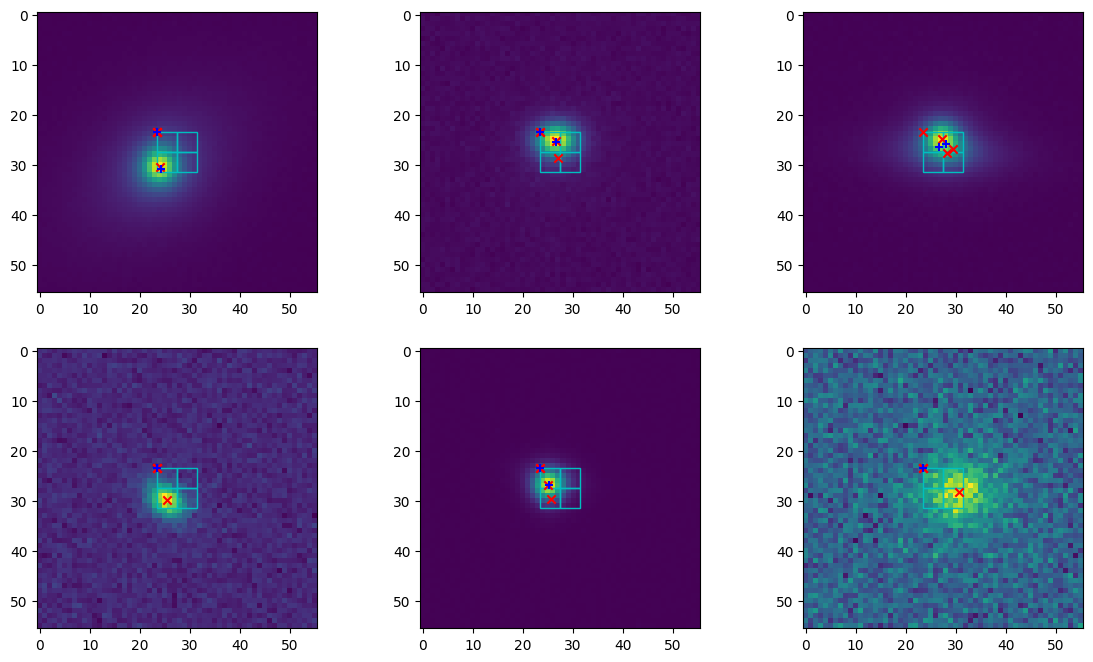

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(128), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # plot the 4 tiles
    for ii in range(2):
        for jj in range(2):
            rect = patches.Rectangle((27.5-4+ii*4, 27.5-4+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
            ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx] - 0.5 + 24
    plocs2 = pred_cat.to_full_params().plocs[idx] - 0.5 + 24
    y1 = plocs1[:, 0]
    x1 = plocs1[:, 1]
    y2 = plocs2[:, 0]
    x2 = plocs2[:, 1]

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Bright sources; 10 tiles per image (full dataset with correct density); no stars

**Notes:** 

In [ ]:
# prepare bigger dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 128 * 11

new_table = catsim_table[catsim_table['i_ab'] < 23 ]

len(new_table)

33051

In [ ]:
dataset = generate_dataset(n_samples, new_table, all_star_mags, 4, 10, psf, slen=40, bp=24, max_shift=0.5, galaxy_prob=1.0)
dataset['n_sources'].sum()

  1%|          | 8/1408 [00:00<00:56, 24.87it/s]

100%|██████████| 1408/1408 [00:41<00:00, 33.69it/s]


tensor(5585)

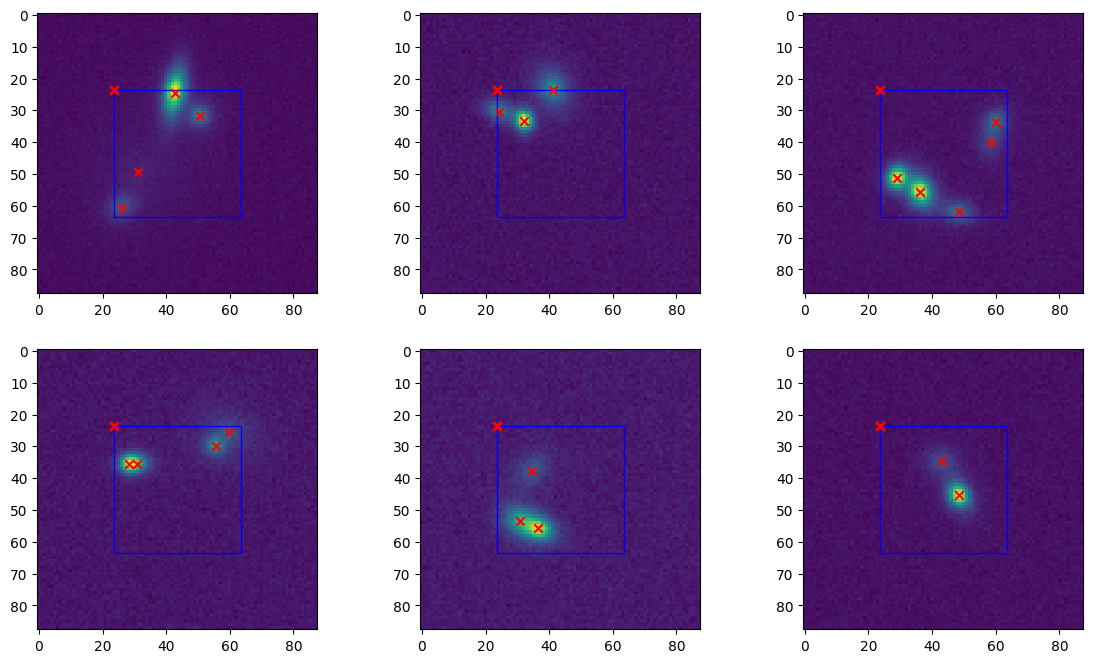

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = dataset['images'][idx][0]

    ax.imshow(np.log10(image))

    # square of 8 pixels centered
    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# train, test split
train_idx = int(n_samples * 10 / 11)
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

In [ ]:
# now save  data
torch.save(train_ds, "train_ds_100_tiles_bright.pt")
torch.save(val_ds, "val_ds_100_tiles_bright.pt")

In [ ]:
# create datasets
train_dataset = SavedGalsimBlends("train_ds_100_tiles_bright.pt", n_samples * 10 // 11, slen=40)
validation_dataset = SavedGalsimBlends("val_ds_100_tiles_bright.pt", n_samples // 11, slen=40)
len(train_dataset)

1280

In [ ]:
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=32)

In [ ]:
# now train on the same batch 100 times with some optimizer 
from torch.optim import Adam
from tqdm import tqdm
input_transform = ConcatBackgroundTransform()
detection_encoder = DetectionEncoder(input_transform)

# gpu 
gpu = torch.device("cuda:0")
detection_encoder.to(gpu)

opt = Adam(detection_encoder.parameters(), lr=1e-4)


for ii in tqdm(range(500), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    detection_encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        losses = detection_encoder.get_loss(images, background, truth_cat)
        loss = losses['loss']
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        running_counter_loss += losses['counter_loss']
        running_locs_loss += losses['locs_loss']
        train_n_batches+=1 

    running_loss /= train_n_batches
    running_counter_loss /= train_n_batches
    running_locs_loss /= train_n_batches

    if ii % 10 == 9:

        print('epoch:', ii, ',training_loss: ', running_loss)
        print('epoch:', ii, ',counter_training_loss: ', running_counter_loss)
        print('epoch:', ii, ',counter_locs_loss: ', running_locs_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   0%|          | 0/500 [00:00<?, ?it/s]

epoch::   2%|▏         | 10/500 [03:30<2:52:41, 21.15s/it]

epoch: 9 ,training_loss:  0.06754691954702138
epoch: 9 ,counter_training_loss:  0.13206213042140008
epoch: 9 ,counter_locs_loss:  -0.06451521161943674


epoch::   4%|▍         | 20/500 [07:02<2:49:31, 21.19s/it]

epoch: 19 ,training_loss:  -0.026571872131899
epoch: 19 ,counter_training_loss:  0.0699519969522953
epoch: 19 ,counter_locs_loss:  -0.09652386903762818


epoch::   6%|▌         | 30/500 [10:34<2:45:57, 21.19s/it]

epoch: 29 ,training_loss:  -0.07168460385873913
epoch: 29 ,counter_training_loss:  0.04710674583911896
epoch: 29 ,counter_locs_loss:  -0.11879134755581618


epoch::   8%|▊         | 40/500 [14:05<2:42:20, 21.18s/it]

epoch: 39 ,training_loss:  -0.09723466457799076
epoch: 39 ,counter_training_loss:  0.03619916052557528
epoch: 39 ,counter_locs_loss:  -0.13343382626771927


epoch::  10%|█         | 50/500 [17:37<2:38:47, 21.17s/it]

epoch: 49 ,training_loss:  -0.10630191536620259
epoch: 49 ,counter_training_loss:  0.030025814892724156
epoch: 49 ,counter_locs_loss:  -0.13632773086428643


epoch::  12%|█▏        | 60/500 [21:09<2:35:20, 21.18s/it]

epoch: 59 ,training_loss:  -0.13951955623924733
epoch: 59 ,counter_training_loss:  0.024343673838302493
epoch: 59 ,counter_locs_loss:  -0.1638632297515869


epoch::  14%|█▍        | 70/500 [24:41<2:31:48, 21.18s/it]

epoch: 69 ,training_loss:  -0.1453637473285198
epoch: 69 ,counter_training_loss:  0.021076681348495184
epoch: 69 ,counter_locs_loss:  -0.16644042916595936


epoch::  16%|█▌        | 80/500 [28:12<2:28:11, 21.17s/it]

epoch: 79 ,training_loss:  -0.16760652624070643
epoch: 79 ,counter_training_loss:  0.017332624830305576
epoch: 79 ,counter_locs_loss:  -0.18493914995342492


epoch::  18%|█▊        | 90/500 [31:44<2:24:38, 21.17s/it]

epoch: 89 ,training_loss:  -0.17291485965251924
epoch: 89 ,counter_training_loss:  0.014828854007646441
epoch: 89 ,counter_locs_loss:  -0.18774371407926083


epoch::  20%|██        | 100/500 [35:16<2:21:10, 21.18s/it]

epoch: 99 ,training_loss:  -0.18760090991854667
epoch: 99 ,counter_training_loss:  0.012644963734783233
epoch: 99 ,counter_locs_loss:  -0.20024587400257587


epoch::  22%|██▏       | 110/500 [38:47<2:17:39, 21.18s/it]

epoch: 109 ,training_loss:  -0.1931873194873333
epoch: 109 ,counter_training_loss:  0.010433414042927325
epoch: 109 ,counter_locs_loss:  -0.20362073555588722


epoch::  24%|██▍       | 120/500 [42:19<2:14:06, 21.17s/it]

epoch: 119 ,training_loss:  -0.20172668248414993
epoch: 119 ,counter_training_loss:  0.009000119171105325
epoch: 119 ,counter_locs_loss:  -0.2107268050312996


epoch::  26%|██▌       | 130/500 [45:51<2:10:29, 21.16s/it]

epoch: 129 ,training_loss:  -0.21387321446090937
epoch: 129 ,counter_training_loss:  0.0076002486050128935
epoch: 129 ,counter_locs_loss:  -0.22147346697747708


epoch::  28%|██▊       | 140/500 [49:23<2:07:03, 21.18s/it]

epoch: 139 ,training_loss:  -0.20879268329590558
epoch: 139 ,counter_training_loss:  0.00683581039775163
epoch: 139 ,counter_locs_loss:  -0.21562849320471286


epoch::  30%|███       | 150/500 [52:54<2:03:29, 21.17s/it]

epoch: 149 ,training_loss:  -0.21573605723679065
epoch: 149 ,counter_training_loss:  0.005654530745232478
epoch: 149 ,counter_locs_loss:  -0.2213905893266201


epoch::  32%|███▏      | 160/500 [56:26<1:59:57, 21.17s/it]

epoch: 159 ,training_loss:  -0.22494196891784668
epoch: 159 ,counter_training_loss:  0.004990334651665762
epoch: 159 ,counter_locs_loss:  -0.22993230447173119


epoch::  34%|███▍      | 170/500 [59:58<1:56:28, 21.18s/it]

epoch: 169 ,training_loss:  -0.20635227635502815
epoch: 169 ,counter_training_loss:  0.004803292691940441
epoch: 169 ,counter_locs_loss:  -0.21115557104349136


epoch::  36%|███▌      | 180/500 [1:03:29<1:52:52, 21.16s/it]

epoch: 179 ,training_loss:  -0.22583449333906175
epoch: 179 ,counter_training_loss:  0.0037722481007222085
epoch: 179 ,counter_locs_loss:  -0.22960674501955508


epoch::  38%|███▊      | 190/500 [1:07:01<1:49:18, 21.15s/it]

epoch: 189 ,training_loss:  -0.23213655985891818
epoch: 189 ,counter_training_loss:  0.003370883935713209
epoch: 189 ,counter_locs_loss:  -0.23550744727253914


epoch::  40%|████      | 200/500 [1:10:33<1:45:55, 21.18s/it]

epoch: 199 ,training_loss:  -0.23134505935013294
epoch: 199 ,counter_training_loss:  0.003087849955772981
epoch: 199 ,counter_locs_loss:  -0.23443291299045085


epoch::  42%|████▏     | 210/500 [1:14:05<1:42:22, 21.18s/it]

epoch: 209 ,training_loss:  -0.238420644775033
epoch: 209 ,counter_training_loss:  0.0026670366583857684
epoch: 209 ,counter_locs_loss:  -0.2410876877605915


epoch::  44%|████▍     | 220/500 [1:17:36<1:38:47, 21.17s/it]

epoch: 219 ,training_loss:  -0.2384052559733391
epoch: 219 ,counter_training_loss:  0.002451268050936051
epoch: 219 ,counter_locs_loss:  -0.24085653088986875


epoch::  46%|████▌     | 230/500 [1:21:08<1:35:15, 21.17s/it]

epoch: 229 ,training_loss:  -0.2442694641649723
epoch: 229 ,counter_training_loss:  0.0022583438927540555
epoch: 229 ,counter_locs_loss:  -0.24652780815958977


epoch::  46%|████▌     | 231/500 [1:21:32<1:34:57, 21.18s/it]


KeyboardInterrupt: 

In [ ]:
for tbatch in train_dl: 
    break

In [ ]:

# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(tbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.sum(dim=(-1, -2))
n_sources2 = pred_cat.n_sources.sum(dim=(-1, -2))
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2
# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(0.8125)


(tensor([3, 4, 5, 4, 4, 4, 0, 3, 1, 5, 2, 2, 2, 5, 4, 2, 5, 2, 4, 5, 3, 4, 5, 4,
         2, 4, 4, 0, 3, 4, 6, 8]),
 tensor([2, 3, 4, 4, 4, 4, 0, 3, 1, 5, 2, 1, 2, 5, 3, 2, 5, 1, 4, 5, 3, 4, 5, 4,
         2, 4, 4, 0, 3, 4, 6, 8]))

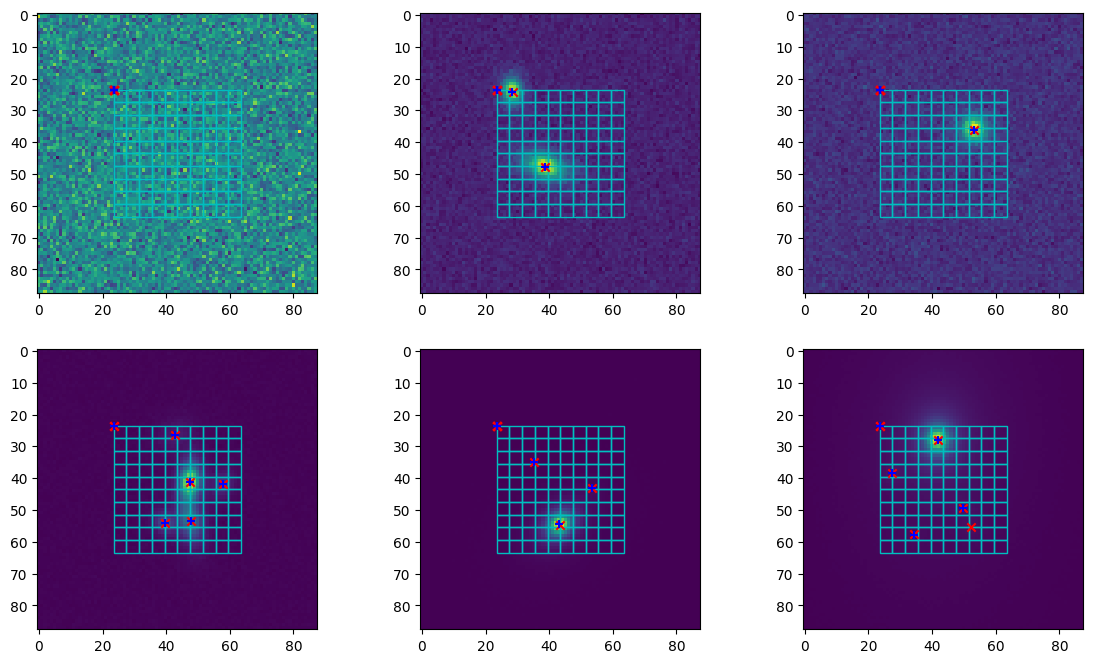

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(32), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # plot the 4 tiles
    for ii in range(10):
        for jj in range(10):
            rect = patches.Rectangle((43.5-20+ii*4, 43.5-20+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
            ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx] - 0.5 + 24
    plocs2 = pred_cat.to_full_params().plocs[idx] - 0.5 + 24
    y1 = plocs1[:, 0]
    x1 = plocs1[:, 1]
    y2 = plocs2[:, 0]
    x2 = plocs2[:, 1]

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


In [ ]:
for vbatch in val_dl: 
    break


# get predictions
model_cpu = detection_encoder.to(torch.device("cpu"))
model_cpu.eval()
images, background, truth_cat = parse_dataset(vbatch)
with torch.no_grad():
    pred_cat = model_cpu.variational_mode(images, background)

In [ ]:
n_sources1 = truth_cat.n_sources.sum(dim=(-1, -2))
n_sources2 = pred_cat.n_sources.sum(dim=(-1, -2))
print(torch.eq(n_sources1, n_sources2).sum() / len(n_sources1))
n_sources1,n_sources2
# assert torch.all(torch.eq(truth_cat.n_sources, pred_cat.n_sources))

tensor(0.4375)


(tensor([7, 4, 2, 2, 5, 7, 6, 6, 2, 4, 2, 2, 4, 2, 2, 4, 4, 2, 6, 1, 3, 4, 8, 3,
         2, 2, 3, 3, 2, 5, 9, 4]),
 tensor([6, 5, 2, 3, 4, 6, 4, 8, 3, 4, 2, 1, 5, 2, 4, 3, 4, 2, 5, 1, 3, 3, 6, 3,
         2, 2, 4, 3, 2, 5, 8, 5]))

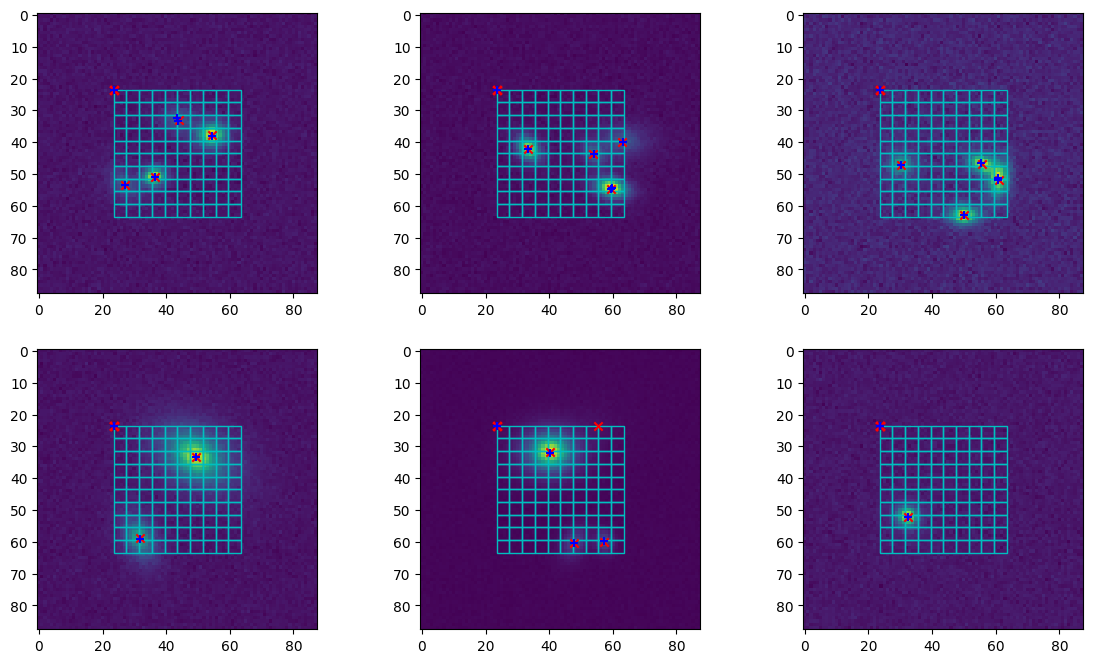

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(32), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(images[idx][0])

    # plot the 4 tiles
    for ii in range(10):
        for jj in range(10):
            rect = patches.Rectangle((43.5-20+ii*4, 43.5-20+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
            ax.add_patch(rect)

    plocs1 = truth_cat.to_full_params().plocs[idx] - 0.5 + 24
    plocs2 = pred_cat.to_full_params().plocs[idx] - 0.5 + 24
    y1 = plocs1[:, 0]
    x1 = plocs1[:, 1]
    y2 = plocs2[:, 0]
    x2 = plocs2[:, 1]

    ax.scatter(x1, y1, marker='x', color='r')
    ax.scatter(x2, y2, marker='+', color='b')


# Scratch

In [ ]:
# check saved dataset is what we expect
train_ds = torch.load("../run/ds/train_ds_7.pt")
noiseless = train_ds['noiseless']
noiseless.shape

torch.Size([15420, 1, 88, 88])

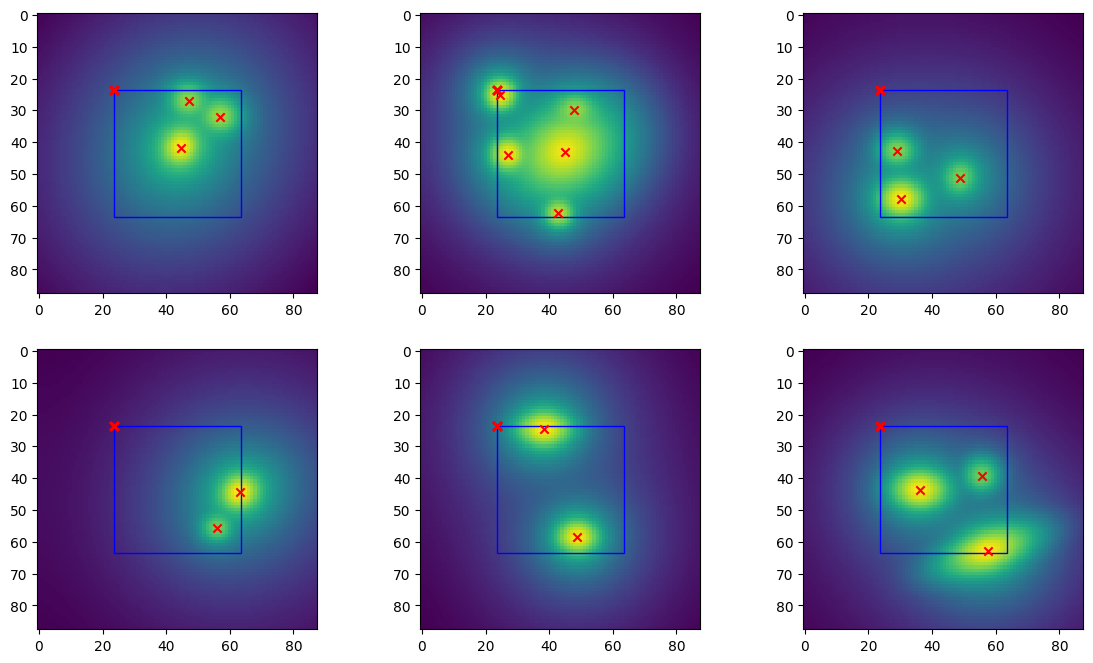

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = train_ds['noiseless'][idx][0]

    ax.imshow(np.log10(image), interpolation='none')

    # square of 8 pixels centered
    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = train_ds['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')
    

In [ ]:
train_ds['n_sources'].float().mean()

tensor(3.4698)

In [ ]:
# what atoub  v4 hwhere its working
val_ds_4 = torch.load('../run/ds/val_ds_4.pt')

In [ ]:
val_ds_4['images'].shape

torch.Size([5140, 1, 88, 88])

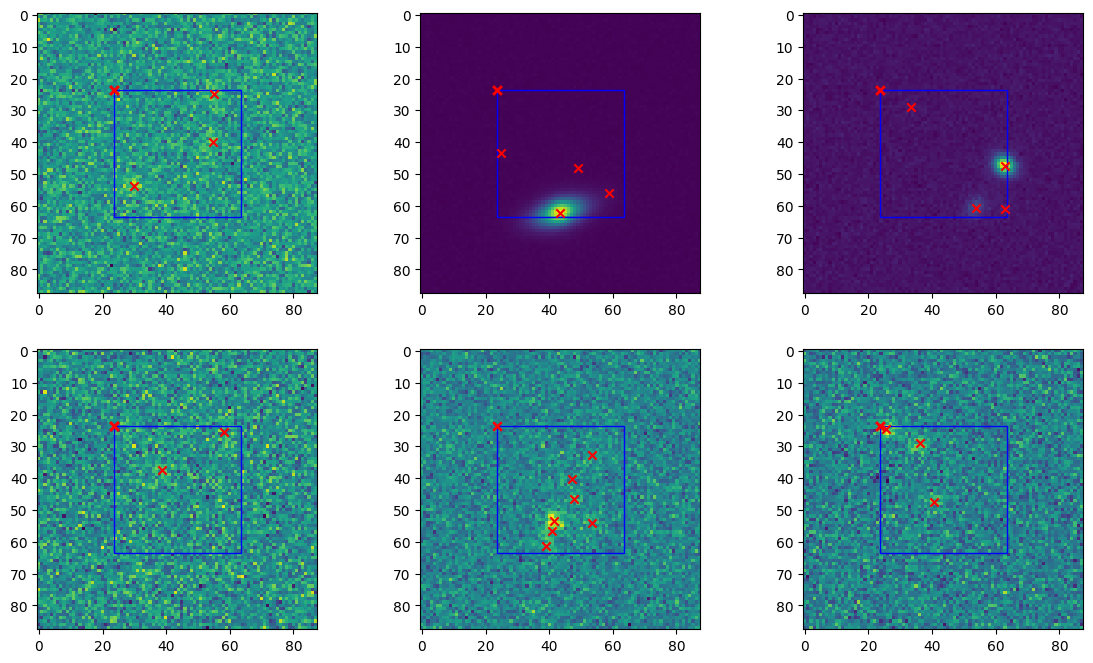

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = val_ds_4['images'][idx][0]

    ax.imshow(np.log10(image), interpolation='none')

    # square of 8 pixels centered
    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = val_ds_4['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')
    

In [ ]:
val_ds_4['n_sources'].float().mean()

tensor(4.0089)

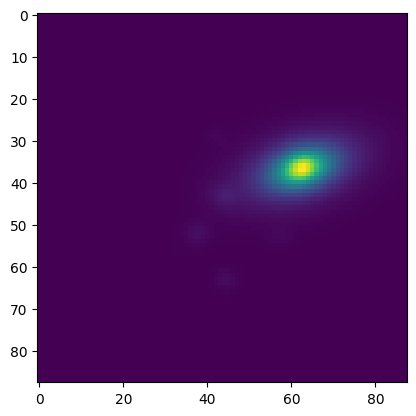

In [ ]:
plt.imshow(noiseless[11,0])

In [ ]:
# create datset of 100 star images 


psf = get_default_lsst_psf()
background = get_default_lsst_background()
all_stars_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")

In [ ]:
from bliss.render_tiles import _validate_border_padding
bp = _validate_border_padding(4, 20)
print(bp)

8


In [ ]:
params = sample_stars(all_stars_mags, 40, 300, 5, 0.5)

In [ ]:
params['locs'].shape

torch.Size([1, 5, 2])

In [ ]:
images = []
cats = []
tile_slen = 4 


for _ in range(5):
    params = sample_stars(all_stars_mags, 40, 300, 5, 0.5)
    print(params['n_stars'], params['locs'].shape)
    full_catalog = convert_star_params_to_full_catalog(params, 40 , 24)
    image, _= render_stars_from_params(params, 40, 24, psf, 5)
    # images.append(image)
    # cats.append(full_catalog)


tensor([3]) torch.Size([1, 5, 2])


AssertionError: 

In [ ]:
print(params)

{'n_stars': tensor([3]), 'locs': tensor([[[0.7101, 0.9736],
         [0.9612, 0.5870],
         [0.5152, 0.7326],
         [0.0000, 0.0000],
         [0.0000, 0.0000]]]), 'star_fluxes': tensor([[[ 200807.],
         [  22483.],
         [3573546.],
         [      0.],
         [      0.]]]), 'star_log_fluxes': tensor([[[12.2101],
         [10.0205],
         [15.0891],
         [ 0.0000],
         [ 0.0000]]])}


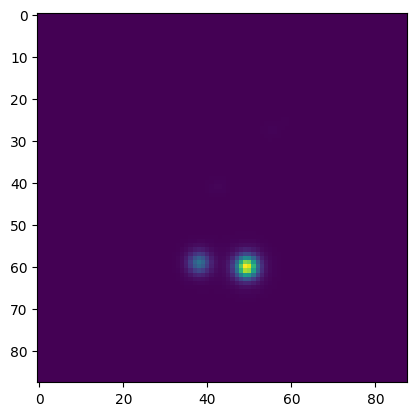

In [ ]:
plt.imshow(images[1][0])

## Test individual galaxy dataset for autoencoder

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
psf = get_default_lsst_psf()

n_samples = 2000

dataset = generate_dataset(n_samples, catsim_table, all_star_mags, psf, max_n_sources=1, galaxy_density=1000, star_density=0, max_shift=0, slen=53, bp=0, add_galaxies_in_padding=False)

100%|██████████| 2000/2000 [00:11<00:00, 173.38it/s]


In [ ]:
assert dataset['n_sources'].eq(1).all()

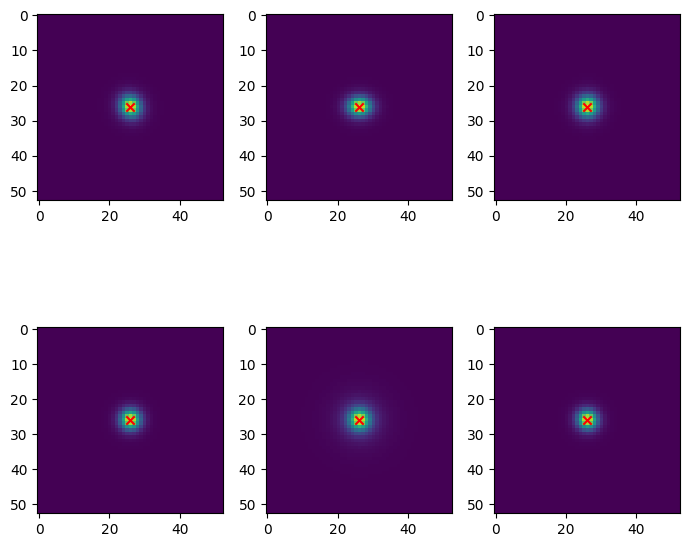

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np


rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(7, 7))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = dataset['noiseless'][idx][0]

    ax.imshow(image, interpolation='none')


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 
    x = plocs[:, 1] - 0.5

    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')
    
plt.tight_layout()